Ce notebook vise à expérimenter l'imputation du salaire dans l'enquête Emploi à l'aide de réseaux de neurones.

Il est composé de cinq parties :
1. Préambule
2. Dataprep

Cette partie inclut notamment la vectorisation des nomenclature à l'aide de l'algorithme Word2Vec implémenté dans le package Gensim.

3. Entraînement du réseau de neurone

A l'aide des packages Tensorflow et Keras. La partie inclut la mise en forme des inputs, la sélection des features et labels, le split test-train, et quelques éléments d'optimisation des hyperparamètres.

4. Métriques de performance

Y compris les effets de l'imputation par réseau de neurones en termes de réduction du biais de non réponse, via l'exploitation des réponses en tranche.

5. Comparaisons avec des modèles linéaires

Plusieurs modèles sont estimés, inspirés par un modèle de Mincer plus ou moins enrichi.

Pour être utilisé ou adapté à votre propre usage, ce notebook peut demander plusieurs modifications. En particulier, les données exploitées sont les fichiers de production (base Z) de l'enquête Emploi, disponibles seulement en interne à l'Insee pour les personnes autorisées. Les fichiers "FPR" (fichiers de production et de recherche), accessibles via le CASD, peuvent être leur être substitués. Il conviendra alors d'adapter la liste des variables, certaines n'étant pas disponibles ou ayant un autre nom dans les fichiers FPR.

# 1. Préambule

In [1]:
import pandas as pd

In [2]:
import gc

In [3]:
import matplotlib

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sn

In [6]:
import numpy as np

In [7]:
import tensorflow as tf

In [8]:
import keras

In [9]:
import copy

In [10]:
import datetime

In [11]:
import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [12]:
import statsmodels.api as sm # import statsmodels 
import statsmodels.formula.api as smf

# 2. DATAPREP

## 2.1 Nettoyage et construction de features

### Importation des données

Les noms des répertoires sont à modifier pour adapter à la structure de votre propre projet

In [13]:
datapath = ''
datapath_vec = ''
modelpath = ''

#### Importation et sauvegarde du dataframe principal

In [14]:
data = pd.read_csv(datapath+'salaires.csv', encoding="latin1", dtype=object)

In [15]:
data.shape

(1531841, 95)

#### Importation des nomenclatures vectorisées

Pour gagner du temps, lorsque l'étape de dataprep est reconduite plusieurs fois, les nomenclatures déjà vectorisées (voir plus loin) peuvent être enregistrées. On peut également importer des nomenclatures vectorisées à partir d'autres sources statistiques.
Ici, nous avons déjà vectorisé les nomenclatures des professions, des secteurs, et des départements français, à partir de l'ensemble des observations de l'enquête Emploi sur la période de l'échantillon d'entraînement (et non pas seulement les observations pour lesquelles on dispose d'un salaire).

Si ces fichiers ne sont pas disponibles, les variables "profession", "secteur" et "département" seront vectorisée normalement dans la suite du script.

In [16]:
profvec = pd.read_csv(datapath_vec+'profvec.csv', encoding="latin1", sep=';', dtype=object)

In [17]:
secvec = pd.read_csv(datapath_vec+'secvec.csv', encoding="latin1", sep=';', dtype=object)

In [18]:
depvec = pd.read_csv(datapath_vec+'depvec.csv', encoding="latin1", sep=';', dtype=object)
depvec["DNAI"] = depvec["DEP"]
depvec["DEPPER"] = depvec["DNAI"]
depvec["DEPMER"] = depvec["DNAI"]

### Construction de features

#### Log des heures, Secteur, Age, Expérience dans l'emploi et expérience potentielle

In [19]:
data.loc[:,"SECT"] = [i[0:3] for i in data.loc[:,"NAFN"].astype("str")]

In [20]:
data.loc[data["DATANT"]==".","DATANT"] = np.nan

In [21]:
data.loc[data["FORDAT"]==".","FORDAT"] = np.nan

In [22]:
data["AGE"] = data["ANNEE"].astype("float")-data["NAIA"].astype("float")
data["EXPE"] = data["ANNEE"].astype("float")-data["DATANT"].astype("float")
data["EXPEPOT"] = data["ANNEE"].astype("float")-data["FORDAT"].astype("float")

In [23]:
data.loc[data["NAIM"]=="99","NAIM"] = np.nan

In [24]:
data["LHHC"]=np.log(data["HHC"].astype('float')+0.1)

#### Merge des nomenclatures vectorisées

In [25]:
data = data.merge(profvec, how='left', on="P")
data = data.drop(columns=["Unnamed: 0","label","color","size"])

In [26]:
data = data.merge(secvec, how='left', on="NAFN")
data = data.drop(columns=["Unnamed: 0","size"])

In [27]:
data = data.merge(depvec[['DepA','DepB','DepC','DEP']], how='left', on="DEP")
data = data.merge(depvec[['DepA','DepB','DepC','DNAI']], how='left', on="DNAI", suffixes=('','_DNAI'))
data = data.merge(depvec[['DepA','DepB','DepC','DEPPER']], how='left', on="DEPPER", suffixes=('','_DEPPER'))
data = data.merge(depvec[['DepA','DepB','DepC','DEPMER']], how='left', on="DEPMER", suffixes=('','_DEPMER'))

In [28]:
data.shape

(1531841, 126)

In [29]:
del(profvec, depvec, secvec)

In [30]:
gc.collect()

63

On supprimera ces variables puisqu'on dispose maintenant de leur version vectorisée

In [31]:
already_vectorized=['P','NAFN','DEP', 'DNAI', 'DEPPER', 'DEPMER']

On supprime également la variable confidentielle "prénom", disponible dans les données de production mais inutile : des essais avec une version vectorisée du prénom n'apporte pas de gain de pouvoir prédictif

In [32]:
data = data.drop(columns='PRENOM')

### Construction de la variable à prédire

In [33]:
data.loc[data["SALMEE"]==".","SALMEE"] = np.nan

On enlève les valeurs utilisées pour coder les refus et ne sait pas"

In [34]:
data.loc[data["SALMEE"]=="9999999","SALMEE"] = np.nan
data.loc[data["SALMEE"]=="9999998","SALMEE"] = np.nan

Ainsi des valeurs qui semblent correspondre à des erreurs des enquêteurs voulant coder le refus

In [35]:
data.loc[data["SALMEE"]=="999999","SALMEE"] = np.nan
data.loc[data["SALMEE"]=="99999","SALMEE"] = np.nan

Ainsi que les valeurs correspondant à 999 999 francs, ancienne valeur maximale de la variable,

In [36]:
data.loc[data["SALMEE"]=="152449","SALMEE"] = np.nan

On conserve, pour l'étape de préparation des données, les observations dont le salaire est manquant, car on exploitera ensuite les réponses par tranche des non-répondants en clair.

Il faudra cependant supprimer ces lignes avant l'entraînement par le RN

In [37]:
#data = data.dropna(subset=['SALMEE'])

In [38]:
data.shape

(1531841, 125)

In [39]:
data["SALMEE"]=data["SALMEE"].astype("float")

On reproduit le découpage des réponses en tranches à partir des salaires effectivement déclarés

In [40]:
data['SALMEET'] = pd.cut(data['SALMEE'],bins=[0,499,999,1249,1499,1999,2499,2999,4999,7999,float("inf")]).astype('O')

On reconstruit le redressement de la variable SALRED de l'enquête Emploi : inclusion d'un douzième des primes annuelles et multiplication par 0.8 des salaires déclarés en brut

In [41]:
data["SALMEERED"]=data["SALMEE"].astype("float")
data["AUTPRIM"]=(data["VALPRE"].astype("float")/12)

In [42]:
data.loc[(data["PRIMS"]=="1")&(0<data["VALPRE"].astype("float"))&(data["VALPRE"].astype("float")<999998),"SALMEERED"] = data["SALMEERED"]+data["AUTPRIM"]

In [43]:
data.loc[data["TYPSAL"]=="2","SALMEERED"] = data["SALMEE"].astype("float")*(0.8)

In [44]:
datasave2 = copy.deepcopy(data)

## 2.2 Retraitement en réels et sélection des variables

Le RN prend pour input des vecteurs réels sans valeurs manquantes. On doit imputer les valeurs manquantes et encoder les variables qualitatives en nombres réels. Pour cela, on distingue plusieurs types de variables (à la main). Les variables numériques seront retraitées pour les valeurs manquantes (imputation par la valeur minimum et ajout d'une indicatrice de valeur manquante). Parmi les variables qualitatives, on distingue les variables avec un grand nombre de modalités, à vectoriser.

### Classement des variables en trois types (quanti, quali, à vectoriser)

In [45]:
data = data.drop(columns=already_vectorized)

In [46]:
data.columns.tolist()

['SALMET',
 'DDIPL',
 'NAIM',
 'NAIA',
 'HH',
 'HT',
 'STATUT',
 'CSE',
 'ANNEE',
 'SEXE',
 'SALMEE',
 'IDENT',
 'ACTEU',
 'EMPNBH',
 'DATANT',
 'DAMOIS',
 'TRIM',
 'DATDEB',
 'RGA',
 'SO',
 'PNAI',
 'NRESID',
 'CODPCL',
 'CSMERE',
 'CSPERE',
 'DNAIM',
 'DNAIP',
 'IMMI',
 'PRIM',
 'PRIMS',
 'REG',
 'REVENT',
 'TPP',
 'TPPRED',
 'HATYEAR',
 'SPE',
 'NIVETD',
 'TYPMEN',
 'PAIMERCDET',
 'PAIPERCDET',
 'NBINDE',
 'NBACTOC',
 'NBENF18A',
 'NBENF6A',
 'NBENF3A',
 'NBENF18MA',
 'SALREDTR',
 'RGI',
 'CODNAFN',
 'HHC',
 'SALRED',
 'NBCHOME',
 'TYPVOIS',
 'RDQ',
 'AUTSAL',
 'TYPSAL',
 'DATDIP',
 'PAIPER',
 'PAIMER',
 'AM2NB',
 'CHPUB',
 'CONTRA',
 'FONCTC',
 'NBTOT',
 'TITC',
 'VALPRE',
 'OCCREF',
 'CSPP',
 'CSPM',
 'QPRC',
 'STAT2',
 'FORDAT',
 'DIPDET',
 'DIPFIN',
 'NIVFIN',
 'NBACTOP',
 'NBACTIF',
 'NBENFIND',
 'NBENFA18',
 'NBENFA15',
 'NBENFA10',
 'NBENFA6',
 'NBENFA3',
 'NBENFA1',
 'NBIND',
 'TYPMEN21',
 'TYPMEN7',
 'CATAU2010',
 'SECT',
 'AGE',
 'EXPE',
 'EXPEPOT',
 'LHHC',
 'A',
 'B',
 '

In [47]:
numlist = ['NAIM','NAIA','ANNEE','DAMOIS','DATANT','ANCA','DATDIP','NRESID','HHC','LHHC','NBTOT','FORDAT','AGE','EXPE',
           'EXPEPOT','DDIPL','A','B','C','D','size_x','SALMEERED','SALMEE','CSPP','CSPM','SECT','DIPDET','CSE','SectA',
           'SectB','SectC','SectD','SectE','SectF','SectG','SectH','SectI','SectJ','size_y','DepA','DepB','DepC',
           'DepA_DNAI','DepB_DNAI','DepC_DNAI','DepA_DEPPER','DepB_DEPPER','DepC_DEPPER','DepA_DEPMER','DepB_DEPMER',
           'DepC_DEPMER','HH','HT','HATYEAR','EMPNBH','SALRED','VALPRE','AUTPRIM','NBINDE','NBACTOC','NBENF18A','NBENF6A','NBENF3A',
           'NBENF18MA','NBCHOME','NBACTOP','NBACTIF','NBENFIND','NBENFA18','NBENFA15','NBENFA10','NBENFA6','NBENFA3',
           'NBENFA1','NBIND']

In [48]:
numl = [i for i in data.columns if i in numlist]

In [49]:
objl = [i for i in data.columns if (i not in numl)]

In [50]:
novectl = ['IDENT','SALMEE','SALMET']

On classe dans la catégorie "à vectoriser" toutes les variables qualitatives avec 20 modalités ou plus, qu'on considère dès lors comme des "nomenclatures". Ce seuil peut bien sûr être modifié.

In [51]:
vectl = [i for i in data.columns if (data[i].nunique()>=20)
         &(i not in numl+novectl)]

In [52]:
vectl

['DATDEB',
 'PNAI',
 'CODPCL',
 'CSMERE',
 'CSPERE',
 'DNAIM',
 'DNAIP',
 'REG',
 'SPE',
 'PAIMERCDET',
 'PAIPERCDET',
 'CODNAFN',
 'PAIPER',
 'PAIMER',
 'DIPFIN',
 'NIVFIN']

In [53]:
outl = [i for i in data.columns if (i not in numl)&(i not in objl)&(i not in vectl)]

In [54]:
outl

[]

### Sélection de variable selon les modèles

Colonnes pour un modèle de Mincer sans les nomenclatures

In [55]:
Mincercola = ['NAIM', 'NAIA', 'STATUT', 'CSE', 'DDIPL', 'ANNEE',
       'SEXE', 'ACTEU', 'LHHC', 'DATANT', 'DAMOIS',
       'RGA', 'PRIM', 'PRIMS', 'REVENT',
       'AUTSAL', 'TYPSAL', 'DATDIP', 'AM2NB', 'CHPUB',
       'CONTRA', 'FONCTC', 'NBTOT', 'TITC', 'TPP', 'OCCREF',
       'QPRC', 'TPPRED', 'IMMI', 'FORDAT',
       'SECT', 'AGE', 'EXPE', 'EXPEPOT', 'SALMEERED','TRIM']

Colonnes pour un modèle de Mincer avec les nomenclatures à dummifier

In [56]:
Mincercolb = ['NAIM', 'NAIA', 'STATUT', 'CSE', 'DDIPL', 'ANNEE',
       'SEXE', 'ACTEU', 'LHHC', 'DATANT', 'DAMOIS',
       'RGA', 'CSPP', 'PRIM', 'PRIMS', 'REVENT', 'DNAI',
       'AUTSAL', 'TYPSAL', 'DATDIP', 'AM2NB', 'CHPUB',
       'CONTRA', 'FONCTC', 'NBTOT', 'TITC', 'TPP', 'OCCREF', 'CSPM',
       'QPRC', 'TPPRED', 'IMMI', 'FORDAT', 'DIPDET',
       'SECT', 'AGE', 'EXPE', 'EXPEPOT', 'SALMEERED', 'P','NAFN','DEP','DEPPER','DEPMER','TRIM']

Colonnes pour un modèle de Mincer proche des variables de SALRED

In [57]:
Mincercolc = ['NAIM', 'NAIA', 'STATUT', 'CSE', 'DDIPL', 'ANNEE',
       'SEXE', 'ACTEU', 'LHHC', 
       'RGA', 'PRIM', 'PRIMS',
       'AUTSAL', 'TYPSAL', 'DATDIP', 'AM2NB', 'CHPUB',
       'CONTRA', 'FONCTC', 'NBTOT', 'TITC', 'TPP', 'OCCREF',
       'QPRC', 'TPPRED', 'FORDAT',
       'SECT', 'AGE', 'EXPE', 'EXPEPOT', 'SALMEERED','TRIM']

### Traitement des valeurs manquantes : indicatrices pour les var quanti, nouvelles catégories pour les var quali

In [58]:
def replace_num_nans(df,col):
    '''
    Arguments :
    df : the dataframe to process
    col : the column to transform
    '''
    if df[col].notnull().any():
        mini=df[col].astype('float').min()
        newcol = col+"_nan"
        df[newcol] = 0
        df.loc[df[col].isnull() , newcol] = 1
        df.loc[df[col].isnull() , col] = mini
    else: df = df.drop(columns = col)
    return df

    
def replace_nans(df, numl, objl):
    '''
    Arguments :
    df : the dataframe to process
    num_col_list : list of col names that are to be numerical columns
    obj_col_list : list of col names that are to be object columns
    '''
    num_col_list = [i for i in df.columns if i in numl]
    obj_col_list = [i for i in df.columns if i in objl]
    print("replacing nan in...")
    print("numerical column...")
    for col in num_col_list:
        print(col)
        if df[col].dtype == 'float':
            if df[col].isnull().any():
                df = replace_num_nans(df,col)
        elif df[col].dtype == 'O':
            df.loc[:,col] = pd.to_numeric(df[col], errors='coerce')
            if df[col].isnull().any():
                df = replace_num_nans(df,col)
    print("categorical column...")
    for col in obj_col_list:
        print(col)
        df.loc[df[col].isnull(), col] = "new_nan"
    return df

### Vectorisation des variables catégorielles de cardinalité élevée

In [59]:
def vectorize_col(df, col, dim=8, groupident="IDENT"):
    '''
    groups categories in "sentences" and then uses gensim word2vec to vectorize the "vocabulary" of categories
    Arguments :
    df  : the dataframe with the col to vectorize and the index to group lines
    col : the column to vectorize
    groupident (string) : the name of the column to group obs and build "sentences" 
    dim : the dimension of the encoding vector
    '''
    if col==groupident: 
        print("Error : column to vectorize and group ident column are the same")
    print("Starting to vectorize column", col)
    savecol = df[col]
    df[col]=df[col].astype(str)
    sentences = df.groupby([groupident])[col].unique()
    sentences = sentences.transform(lambda x: x.tolist()).tolist()
    model = gensim.models.Word2Vec(sentences, min_count=1, vector_size=dim)
    All = list(np.unique(df[col]))
    Pcoord=([list(model.wv[i]) for i in All])
    colvec = pd.DataFrame(Pcoord)
    colvec = colvec.set_axis([col+'_vec'+str(x) for x in (range(dim))], axis=1, inplace=False)
    colvec[col] = All
    df[col]=savecol
    return colvec

def col2vec(df, vectl, groupident="IDENT", dim=8):
    '''
    Applies vectorize_col to all columns in a list (vectl)
    Arguments :
    df (pandas dataframe) : the dataframe with the columns to vectorize and the index to group lines
    vectl (list of strings) : the list of column names to vectorize
    groupident (string) : the name of the column to group obs and build "sentences" 
    dim (int) : the dimension of the encoding vector
    '''
    vect_col_list = [i for i in df.columns if i in vectl]
    colnum = len(vect_col_list)
    i = 0
    for col in vect_col_list:
        print(i, "/", colnum, " columns vectorized")
        i = i+1
        df = df.merge(vectorize_col(df, col, dim=dim, groupident=groupident), how='left', on=col)
        df = df.drop(columns=col)
    return df 

#### Encodage OneHot des var quali de cardinalité faible

In [60]:
def oneHotEncode(df,colNames):
    col_list = [i for i in df.columns if i in colNames]
    print("OneHotEncoding column...")
    for col in col_list:
        if( df[col].dtype == np.dtype('object')):
            if df[col].nunique()<2000:
                print(col)
                dummies = pd.get_dummies(df[col],prefix=col)
                df = pd.concat([df,dummies],axis=1)

                #drop the encoded column
                df.drop([col],axis = 1 , inplace=True)
            else :
                print('Column {} not encoded : number of unique values too large'.format(col))
    return df

In [61]:
print(data.shape)
data = replace_nans(data, numl, objl)
newdata = data.copy()
data = newdata
print(data.shape)
del(newdata)

(1531841, 122)
replacing nan in...
numerical column...
DDIPL
NAIM
NAIA
HH
HT
CSE
ANNEE
SALMEE
EMPNBH
DATANT
DAMOIS
NRESID
HATYEAR
NBINDE
NBACTOC
NBENF18A
NBENF6A
NBENF3A
NBENF18MA
HHC
SALRED
NBCHOME
DATDIP
NBTOT
VALPRE
CSPP
CSPM
FORDAT
DIPDET
NBACTOP
NBACTIF
NBENFIND
NBENFA18
NBENFA15
NBENFA10
NBENFA6
NBENFA3
NBENFA1
NBIND
SECT
AGE
EXPE
EXPEPOT
LHHC
A
B
C
D
SectA
SectB
SectC
SectD
SectE
SectF


Y:\Logiciels\Python\environnements\datascience\conda_datascience_py37_20211007\lib\site-packages\ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


SectG
SectH
SectI
SectJ
DepA
DepB
DepC
DepA_DNAI
DepB_DNAI
DepC_DNAI
DepA_DEPPER
DepB_DEPPER
DepC_DEPPER
DepA_DEPMER
DepB_DEPMER
DepC_DEPMER
SALMEERED
AUTPRIM
categorical column...
SALMET
STATUT
SEXE
IDENT
ACTEU
TRIM
DATDEB
RGA
SO
PNAI
CODPCL
CSMERE
CSPERE
DNAIM
DNAIP
IMMI
PRIM
PRIMS
REG
REVENT
TPP
TPPRED
SPE
NIVETD
TYPMEN
PAIMERCDET
PAIPERCDET
SALREDTR
RGI
CODNAFN
TYPVOIS
RDQ
AUTSAL
TYPSAL
PAIPER
PAIMER
AM2NB
CHPUB
CONTRA
FONCTC
TITC
OCCREF
QPRC
STAT2
DIPFIN
NIVFIN
TYPMEN21
TYPMEN7
CATAU2010
SALMEET
(1531841, 191)


In [62]:
data.columns[data.isnull().any()]

Index([], dtype='object')

In [63]:
data = col2vec(data, vectl, dim=2)

0 / 16  columns vectorized
Starting to vectorize column DATDEB


2022-10-04 17:43:45,052 : INFO : collecting all words and their counts
2022-10-04 17:43:45,054 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:43:45,068 : INFO : PROGRESS: at sentence #10000, processed 14299 words, keeping 440 word types
2022-10-04 17:43:45,076 : INFO : PROGRESS: at sentence #20000, processed 28371 words, keeping 456 word types
2022-10-04 17:43:45,082 : INFO : PROGRESS: at sentence #30000, processed 42701 words, keeping 458 word types
2022-10-04 17:43:45,088 : INFO : PROGRESS: at sentence #40000, processed 57951 words, keeping 458 word types
2022-10-04 17:43:45,094 : INFO : PROGRESS: at sentence #50000, processed 71906 words, keeping 458 word types
2022-10-04 17:43:45,105 : INFO : PROGRESS: at sentence #60000, processed 87987 words, keeping 458 word types
2022-10-04 17:43:45,114 : INFO : PROGRESS: at sentence #70000, processed 104182 words, keeping 458 word types
2022-10-04 17:43:45,121 : INFO : PROGRESS: at sentence #80000, pro

1 / 16  columns vectorized
Starting to vectorize column PNAI


2022-10-04 17:45:05,338 : INFO : collecting all words and their counts
2022-10-04 17:45:05,340 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:45:05,352 : INFO : PROGRESS: at sentence #10000, processed 10453 words, keeping 101 word types
2022-10-04 17:45:05,362 : INFO : PROGRESS: at sentence #20000, processed 20832 words, keeping 123 word types
2022-10-04 17:45:05,368 : INFO : PROGRESS: at sentence #30000, processed 31288 words, keeping 133 word types
2022-10-04 17:45:05,374 : INFO : PROGRESS: at sentence #40000, processed 41821 words, keeping 149 word types
2022-10-04 17:45:05,380 : INFO : PROGRESS: at sentence #50000, processed 52236 words, keeping 155 word types
2022-10-04 17:45:05,387 : INFO : PROGRESS: at sentence #60000, processed 62890 words, keeping 158 word types
2022-10-04 17:45:05,392 : INFO : PROGRESS: at sentence #70000, processed 73539 words, keeping 163 word types
2022-10-04 17:45:05,398 : INFO : PROGRESS: at sentence #80000, proc

2 / 16  columns vectorized
Starting to vectorize column CODPCL


2022-10-04 17:46:24,431 : INFO : collecting all words and their counts
2022-10-04 17:46:24,433 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:46:24,446 : INFO : PROGRESS: at sentence #10000, processed 14318 words, keeping 422 word types
2022-10-04 17:46:24,454 : INFO : PROGRESS: at sentence #20000, processed 28274 words, keeping 438 word types
2022-10-04 17:46:24,463 : INFO : PROGRESS: at sentence #30000, processed 42526 words, keeping 447 word types
2022-10-04 17:46:24,470 : INFO : PROGRESS: at sentence #40000, processed 57648 words, keeping 459 word types
2022-10-04 17:46:24,479 : INFO : PROGRESS: at sentence #50000, processed 71726 words, keeping 465 word types
2022-10-04 17:46:24,486 : INFO : PROGRESS: at sentence #60000, processed 87867 words, keeping 471 word types
2022-10-04 17:46:24,494 : INFO : PROGRESS: at sentence #70000, processed 103790 words, keeping 475 word types
2022-10-04 17:46:24,503 : INFO : PROGRESS: at sentence #80000, pro

3 / 16  columns vectorized
Starting to vectorize column CSMERE


2022-10-04 17:47:43,564 : INFO : collecting all words and their counts
2022-10-04 17:47:43,566 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:47:43,572 : INFO : PROGRESS: at sentence #10000, processed 10236 words, keeping 30 word types
2022-10-04 17:47:43,584 : INFO : PROGRESS: at sentence #20000, processed 20466 words, keeping 36 word types
2022-10-04 17:47:43,591 : INFO : PROGRESS: at sentence #30000, processed 30697 words, keeping 37 word types
2022-10-04 17:47:43,596 : INFO : PROGRESS: at sentence #40000, processed 40978 words, keeping 37 word types
2022-10-04 17:47:43,602 : INFO : PROGRESS: at sentence #50000, processed 51216 words, keeping 39 word types
2022-10-04 17:47:43,607 : INFO : PROGRESS: at sentence #60000, processed 61589 words, keeping 40 word types
2022-10-04 17:47:43,613 : INFO : PROGRESS: at sentence #70000, processed 71942 words, keeping 41 word types
2022-10-04 17:47:43,618 : INFO : PROGRESS: at sentence #80000, processed 8

4 / 16  columns vectorized
Starting to vectorize column CSPERE


2022-10-04 17:49:01,450 : INFO : collecting all words and their counts
2022-10-04 17:49:01,452 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:49:01,462 : INFO : PROGRESS: at sentence #10000, processed 10178 words, keeping 34 word types
2022-10-04 17:49:01,473 : INFO : PROGRESS: at sentence #20000, processed 20361 words, keeping 38 word types
2022-10-04 17:49:01,481 : INFO : PROGRESS: at sentence #30000, processed 30555 words, keeping 38 word types
2022-10-04 17:49:01,488 : INFO : PROGRESS: at sentence #40000, processed 40778 words, keeping 40 word types
2022-10-04 17:49:01,493 : INFO : PROGRESS: at sentence #50000, processed 50963 words, keeping 40 word types
2022-10-04 17:49:01,499 : INFO : PROGRESS: at sentence #60000, processed 61267 words, keeping 40 word types
2022-10-04 17:49:01,506 : INFO : PROGRESS: at sentence #70000, processed 71560 words, keeping 40 word types
2022-10-04 17:49:01,515 : INFO : PROGRESS: at sentence #80000, processed 8

5 / 16  columns vectorized
Starting to vectorize column DNAIM


2022-10-04 17:50:19,313 : INFO : collecting all words and their counts
2022-10-04 17:50:19,315 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:50:19,327 : INFO : PROGRESS: at sentence #10000, processed 11949 words, keeping 103 word types
2022-10-04 17:50:19,336 : INFO : PROGRESS: at sentence #20000, processed 23756 words, keeping 104 word types
2022-10-04 17:50:19,343 : INFO : PROGRESS: at sentence #30000, processed 35608 words, keeping 104 word types
2022-10-04 17:50:19,349 : INFO : PROGRESS: at sentence #40000, processed 47827 words, keeping 104 word types
2022-10-04 17:50:19,355 : INFO : PROGRESS: at sentence #50000, processed 59472 words, keeping 104 word types
2022-10-04 17:50:19,361 : INFO : PROGRESS: at sentence #60000, processed 72145 words, keeping 104 word types
2022-10-04 17:50:19,367 : INFO : PROGRESS: at sentence #70000, processed 84806 words, keeping 104 word types
2022-10-04 17:50:19,373 : INFO : PROGRESS: at sentence #80000, proc

6 / 16  columns vectorized
Starting to vectorize column DNAIP


2022-10-04 17:51:35,595 : INFO : collecting all words and their counts
2022-10-04 17:51:35,597 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:51:35,604 : INFO : PROGRESS: at sentence #10000, processed 11945 words, keeping 103 word types
2022-10-04 17:51:35,611 : INFO : PROGRESS: at sentence #20000, processed 23749 words, keeping 103 word types
2022-10-04 17:51:35,617 : INFO : PROGRESS: at sentence #30000, processed 35574 words, keeping 103 word types
2022-10-04 17:51:35,624 : INFO : PROGRESS: at sentence #40000, processed 47757 words, keeping 103 word types
2022-10-04 17:51:35,635 : INFO : PROGRESS: at sentence #50000, processed 59406 words, keeping 103 word types
2022-10-04 17:51:35,642 : INFO : PROGRESS: at sentence #60000, processed 72129 words, keeping 103 word types
2022-10-04 17:51:35,653 : INFO : PROGRESS: at sentence #70000, processed 84805 words, keeping 104 word types
2022-10-04 17:51:35,661 : INFO : PROGRESS: at sentence #80000, proc

7 / 16  columns vectorized
Starting to vectorize column REG


2022-10-04 17:52:52,347 : INFO : collecting all words and their counts
2022-10-04 17:52:52,349 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:52:52,363 : INFO : PROGRESS: at sentence #10000, processed 10000 words, keeping 23 word types
2022-10-04 17:52:52,370 : INFO : PROGRESS: at sentence #20000, processed 20000 words, keeping 23 word types
2022-10-04 17:52:52,376 : INFO : PROGRESS: at sentence #30000, processed 30000 words, keeping 23 word types
2022-10-04 17:52:52,382 : INFO : PROGRESS: at sentence #40000, processed 40000 words, keeping 23 word types
2022-10-04 17:52:52,387 : INFO : PROGRESS: at sentence #50000, processed 50000 words, keeping 23 word types
2022-10-04 17:52:52,394 : INFO : PROGRESS: at sentence #60000, processed 60000 words, keeping 23 word types
2022-10-04 17:52:52,400 : INFO : PROGRESS: at sentence #70000, processed 70000 words, keeping 23 word types
2022-10-04 17:52:52,405 : INFO : PROGRESS: at sentence #80000, processed 8

8 / 16  columns vectorized
Starting to vectorize column SPE


2022-10-04 17:54:08,303 : INFO : collecting all words and their counts
2022-10-04 17:54:08,305 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:54:08,311 : INFO : PROGRESS: at sentence #10000, processed 13641 words, keeping 85 word types
2022-10-04 17:54:08,318 : INFO : PROGRESS: at sentence #20000, processed 27006 words, keeping 86 word types
2022-10-04 17:54:08,325 : INFO : PROGRESS: at sentence #30000, processed 40575 words, keeping 86 word types
2022-10-04 17:54:08,331 : INFO : PROGRESS: at sentence #40000, processed 54910 words, keeping 86 word types
2022-10-04 17:54:08,337 : INFO : PROGRESS: at sentence #50000, processed 68280 words, keeping 86 word types
2022-10-04 17:54:08,343 : INFO : PROGRESS: at sentence #60000, processed 83451 words, keeping 86 word types
2022-10-04 17:54:08,349 : INFO : PROGRESS: at sentence #70000, processed 98453 words, keeping 86 word types
2022-10-04 17:54:08,356 : INFO : PROGRESS: at sentence #80000, processed 1

9 / 16  columns vectorized
Starting to vectorize column PAIMERCDET


2022-10-04 17:55:24,177 : INFO : collecting all words and their counts
2022-10-04 17:55:24,179 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:55:24,191 : INFO : PROGRESS: at sentence #10000, processed 10903 words, keeping 94 word types
2022-10-04 17:55:24,200 : INFO : PROGRESS: at sentence #20000, processed 21719 words, keeping 118 word types
2022-10-04 17:55:24,207 : INFO : PROGRESS: at sentence #30000, processed 32590 words, keeping 129 word types
2022-10-04 17:55:24,213 : INFO : PROGRESS: at sentence #40000, processed 43656 words, keeping 140 word types
2022-10-04 17:55:24,219 : INFO : PROGRESS: at sentence #50000, processed 54368 words, keeping 147 word types
2022-10-04 17:55:24,225 : INFO : PROGRESS: at sentence #60000, processed 65692 words, keeping 153 word types
2022-10-04 17:55:24,231 : INFO : PROGRESS: at sentence #70000, processed 76925 words, keeping 160 word types
2022-10-04 17:55:24,237 : INFO : PROGRESS: at sentence #80000, proce

10 / 16  columns vectorized
Starting to vectorize column PAIPERCDET


2022-10-04 17:56:39,469 : INFO : collecting all words and their counts
2022-10-04 17:56:39,471 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:56:39,485 : INFO : PROGRESS: at sentence #10000, processed 10970 words, keeping 91 word types
2022-10-04 17:56:39,493 : INFO : PROGRESS: at sentence #20000, processed 21812 words, keeping 120 word types
2022-10-04 17:56:39,499 : INFO : PROGRESS: at sentence #30000, processed 32700 words, keeping 128 word types
2022-10-04 17:56:39,505 : INFO : PROGRESS: at sentence #40000, processed 43786 words, keeping 139 word types
2022-10-04 17:56:39,511 : INFO : PROGRESS: at sentence #50000, processed 54566 words, keeping 143 word types
2022-10-04 17:56:39,516 : INFO : PROGRESS: at sentence #60000, processed 66000 words, keeping 150 word types
2022-10-04 17:56:39,522 : INFO : PROGRESS: at sentence #70000, processed 77291 words, keeping 154 word types
2022-10-04 17:56:39,528 : INFO : PROGRESS: at sentence #80000, proce

11 / 16  columns vectorized
Starting to vectorize column CODNAFN


2022-10-04 17:57:53,672 : INFO : collecting all words and their counts
2022-10-04 17:57:53,674 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:57:53,688 : INFO : PROGRESS: at sentence #10000, processed 12296 words, keeping 554 word types
2022-10-04 17:57:53,695 : INFO : PROGRESS: at sentence #20000, processed 24227 words, keeping 619 word types
2022-10-04 17:57:53,704 : INFO : PROGRESS: at sentence #30000, processed 36756 words, keeping 657 word types
2022-10-04 17:57:53,710 : INFO : PROGRESS: at sentence #40000, processed 49781 words, keeping 684 word types
2022-10-04 17:57:53,717 : INFO : PROGRESS: at sentence #50000, processed 62013 words, keeping 697 word types
2022-10-04 17:57:53,725 : INFO : PROGRESS: at sentence #60000, processed 75278 words, keeping 707 word types
2022-10-04 17:57:53,731 : INFO : PROGRESS: at sentence #70000, processed 88411 words, keeping 719 word types
2022-10-04 17:57:53,738 : INFO : PROGRESS: at sentence #80000, proc

12 / 16  columns vectorized
Starting to vectorize column PAIPER


2022-10-04 17:59:07,704 : INFO : collecting all words and their counts
2022-10-04 17:59:07,706 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 17:59:07,711 : INFO : PROGRESS: at sentence #10000, processed 10000 words, keeping 1 word types
2022-10-04 17:59:07,717 : INFO : PROGRESS: at sentence #20000, processed 20000 words, keeping 1 word types
2022-10-04 17:59:07,723 : INFO : PROGRESS: at sentence #30000, processed 30000 words, keeping 1 word types
2022-10-04 17:59:07,728 : INFO : PROGRESS: at sentence #40000, processed 40000 words, keeping 1 word types
2022-10-04 17:59:07,733 : INFO : PROGRESS: at sentence #50000, processed 50000 words, keeping 1 word types
2022-10-04 17:59:07,738 : INFO : PROGRESS: at sentence #60000, processed 60000 words, keeping 1 word types
2022-10-04 17:59:07,747 : INFO : PROGRESS: at sentence #70000, processed 70000 words, keeping 1 word types
2022-10-04 17:59:07,752 : INFO : PROGRESS: at sentence #80000, processed 80804 wo

13 / 16  columns vectorized
Starting to vectorize column PAIMER


2022-10-04 18:00:20,322 : INFO : collecting all words and their counts
2022-10-04 18:00:20,324 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 18:00:20,334 : INFO : PROGRESS: at sentence #10000, processed 10000 words, keeping 1 word types
2022-10-04 18:00:20,343 : INFO : PROGRESS: at sentence #20000, processed 20000 words, keeping 1 word types
2022-10-04 18:00:20,350 : INFO : PROGRESS: at sentence #30000, processed 30000 words, keeping 1 word types
2022-10-04 18:00:20,355 : INFO : PROGRESS: at sentence #40000, processed 40000 words, keeping 1 word types
2022-10-04 18:00:20,360 : INFO : PROGRESS: at sentence #50000, processed 50000 words, keeping 1 word types
2022-10-04 18:00:20,365 : INFO : PROGRESS: at sentence #60000, processed 60000 words, keeping 1 word types
2022-10-04 18:00:20,370 : INFO : PROGRESS: at sentence #70000, processed 70000 words, keeping 1 word types
2022-10-04 18:00:20,375 : INFO : PROGRESS: at sentence #80000, processed 80799 wo

14 / 16  columns vectorized
Starting to vectorize column DIPFIN


2022-10-04 18:01:33,703 : INFO : collecting all words and their counts
2022-10-04 18:01:33,705 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 18:01:33,720 : INFO : PROGRESS: at sentence #10000, processed 10000 words, keeping 1 word types
2022-10-04 18:01:33,727 : INFO : PROGRESS: at sentence #20000, processed 20000 words, keeping 1 word types
2022-10-04 18:01:33,735 : INFO : PROGRESS: at sentence #30000, processed 30000 words, keeping 1 word types
2022-10-04 18:01:33,740 : INFO : PROGRESS: at sentence #40000, processed 40000 words, keeping 1 word types
2022-10-04 18:01:33,745 : INFO : PROGRESS: at sentence #50000, processed 50000 words, keeping 1 word types
2022-10-04 18:01:33,750 : INFO : PROGRESS: at sentence #60000, processed 60000 words, keeping 1 word types
2022-10-04 18:01:33,755 : INFO : PROGRESS: at sentence #70000, processed 70000 words, keeping 1 word types
2022-10-04 18:01:33,761 : INFO : PROGRESS: at sentence #80000, processed 81041 wo

15 / 16  columns vectorized
Starting to vectorize column NIVFIN


2022-10-04 18:02:47,322 : INFO : collecting all words and their counts
2022-10-04 18:02:47,324 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-04 18:02:47,329 : INFO : PROGRESS: at sentence #10000, processed 10000 words, keeping 1 word types
2022-10-04 18:02:47,335 : INFO : PROGRESS: at sentence #20000, processed 20000 words, keeping 1 word types
2022-10-04 18:02:47,340 : INFO : PROGRESS: at sentence #30000, processed 30000 words, keeping 1 word types
2022-10-04 18:02:47,345 : INFO : PROGRESS: at sentence #40000, processed 40000 words, keeping 1 word types
2022-10-04 18:02:47,354 : INFO : PROGRESS: at sentence #50000, processed 50000 words, keeping 1 word types
2022-10-04 18:02:47,359 : INFO : PROGRESS: at sentence #60000, processed 60000 words, keeping 1 word types
2022-10-04 18:02:47,365 : INFO : PROGRESS: at sentence #70000, processed 70000 words, keeping 1 word types
2022-10-04 18:02:47,371 : INFO : PROGRESS: at sentence #80000, processed 81049 wo

In [64]:
print('There were {} columns before encoding categorical features'.format(data.shape[1]))
data = oneHotEncode(data, objl)
print('There are {} columns after encoding categorical features'.format(data.shape[1]))

There were 207 columns before encoding categorical features
OneHotEncoding column...
SALMET
STATUT
SEXE
Column IDENT not encoded : number of unique values too large
ACTEU
TRIM
RGA
SO
IMMI
PRIM
PRIMS
REVENT
TPP
TPPRED
NIVETD
TYPMEN
SALREDTR
RGI
TYPVOIS
RDQ
AUTSAL
TYPSAL
AM2NB
CHPUB
CONTRA
FONCTC
TITC
OCCREF
QPRC
STAT2
TYPMEN21
TYPMEN7
CATAU2010
SALMEET
There are 423 columns after encoding categorical features


In [65]:
df = data

In [66]:
del(data)

In [67]:
gc.collect()

63

# 3. Prédiction par réseau de neurone

On vérifie qu'il n'y a plus de valeurs manquantes. Dans le cas contraire, on cherche les colonnes concernées.

In [68]:
df.shape

(1531841, 423)

In [69]:
df.columns[df.isnull().any()]

Index([], dtype='object')

## 3.1 Choix des prédicteurs


In [70]:
complete_col_list = df.columns.tolist()

In [71]:
complete_col_list

['DDIPL',
 'NAIM',
 'NAIA',
 'HH',
 'HT',
 'CSE',
 'ANNEE',
 'SALMEE',
 'IDENT',
 'EMPNBH',
 'DATANT',
 'DAMOIS',
 'NRESID',
 'HATYEAR',
 'NBINDE',
 'NBACTOC',
 'NBENF18A',
 'NBENF6A',
 'NBENF3A',
 'NBENF18MA',
 'HHC',
 'SALRED',
 'NBCHOME',
 'DATDIP',
 'NBTOT',
 'VALPRE',
 'CSPP',
 'CSPM',
 'FORDAT',
 'DIPDET',
 'NBACTOP',
 'NBACTIF',
 'NBENFIND',
 'NBENFA18',
 'NBENFA15',
 'NBENFA10',
 'NBENFA6',
 'NBENFA3',
 'NBENFA1',
 'NBIND',
 'SECT',
 'AGE',
 'EXPE',
 'EXPEPOT',
 'LHHC',
 'A',
 'B',
 'C',
 'D',
 'SectA',
 'SectB',
 'SectC',
 'SectD',
 'SectE',
 'SectF',
 'SectG',
 'SectH',
 'SectI',
 'SectJ',
 'DepA',
 'DepB',
 'DepC',
 'DepA_DNAI',
 'DepB_DNAI',
 'DepC_DNAI',
 'DepA_DEPPER',
 'DepB_DEPPER',
 'DepC_DEPPER',
 'DepA_DEPMER',
 'DepB_DEPMER',
 'DepC_DEPMER',
 'SALMEERED',
 'AUTPRIM',
 'DDIPL_nan',
 'NAIM_nan',
 'HH_nan',
 'HT_nan',
 'CSE_nan',
 'SALMEE_nan',
 'EMPNBH_nan',
 'DATANT_nan',
 'DAMOIS_nan',
 'NRESID_nan',
 'HATYEAR_nan',
 'NBINDE_nan',
 'NBACTOC_nan',
 'NBENF18A_nan',
 '

Il est possible de simuler différents types de comportement de non-réponse en fonction des variables que l'on choisi d'exclure. S'il est nécessaire, évidemment, d'exclure les variables des salaire SALMEE et SALRED, on pourrait vouloir intégrer les réponses aux questions sur le salaire en tranche, les primes, ou les revenus issus d'une activité indépendante.

Pour le moment, on exclut toutes ces variables.

In [72]:
ylist=['SALMEE',"SALMEERED",'SALMEE_nan','SALMEERED_nan'] 
salvarlist=['SALRED','SALRED_nan','VALPRE','VALPRE_nan','SALMET_A','SALMET_B','SALMET_C','SALMET_D','SALMET_E',
            'SALMET_F','SALMET_G','SALMET_H','SALMET_I','SALMET_J','SALMET_1','SALMET_2','SALMET_3','SALMET_4',
            'SALMET_5','SALMET_6','SALMET_7','SALMET_8','SALMET_9','SALMET_10','SALMET_98','SALMET_99',
            'SALMET_new_nan','SALREDTR_A','SALREDTR_B','SALREDTR_C','SALREDTR_D','SALREDTR_E','SALREDTR_F',
            'SALREDTR_G','SALREDTR_H','SALREDTR_I','SALREDTR_J','SALREDTR_new_nan']

In [73]:
saltranchelist=['SALMET_A','SALMET_B','SALMET_C','SALMET_D','SALMET_E','SALMET_F','SALMET_G','SALMET_H','SALMET_I',
                'SALMET_J','SALMET_1','SALMET_2','SALMET_3','SALMET_4','SALMET_5','SALMET_6','SALMET_7','SALMET_8',
                'SALMET_9','SALMET_10','SALMET_98','SALMET_99','SALMET_new_nan','SALREDTR_A','SALREDTR_B','SALREDTR_C',
                'SALREDTR_D','SALREDTR_E','SALREDTR_F','SALREDTR_G','SALREDTR_H','SALREDTR_I','SALREDTR_J',
                'SALREDTR_new_nan']

In [74]:
salmeetlist = ['SALMEET_(0.0, 499.0]','SALMEET_(499.0, 999.0]','SALMEET_(999.0, 1249.0]','SALMEET_(1249.0, 1499.0]',
               'SALMEET_(1499.0, 1999.0]','SALMEET_(1999.0, 2499.0]','SALMEET_(2499.0, 2999.0]','SALMEET_(2999.0, 4999.0]',
               'SALMEET_(4999.0, 7999.0]','SALMEET_(7999.0, inf]','SALMEET_new_nan']

In [75]:
primlist = ["AUTPRIM","AUTPRIM_nan","VALPRE","VALPRE_nan","PRIM_1","PRIM_2","PRIM_9","PRIM_new_nan",
            "PRIMS_1","PRIMS_2","PRIMS_9","PRIMS_new_nan"]

In [76]:
reventlist = ['REVENT_8','REVENT_9','REVENT_A','REVENT_B','REVENT_C','REVENT_D','REVENT_E','REVENT_F','REVENT_G',
              'REVENT_H','REVENT_I','REVENT_J','REVENT_new_nan']

In [77]:
outl=['DEP', 'P', 'IDENT', 'DNAI', 'NAFN', 'DEPPER', 'DEPMER']

In [78]:
excludlist = [i for i in ylist+salvarlist+outl+salmeetlist+primlist+reventlist]

In [79]:
excludlist

['SALMEE',
 'SALMEERED',
 'SALMEE_nan',
 'SALMEERED_nan',
 'SALRED',
 'SALRED_nan',
 'VALPRE',
 'VALPRE_nan',
 'SALMET_A',
 'SALMET_B',
 'SALMET_C',
 'SALMET_D',
 'SALMET_E',
 'SALMET_F',
 'SALMET_G',
 'SALMET_H',
 'SALMET_I',
 'SALMET_J',
 'SALMET_1',
 'SALMET_2',
 'SALMET_3',
 'SALMET_4',
 'SALMET_5',
 'SALMET_6',
 'SALMET_7',
 'SALMET_8',
 'SALMET_9',
 'SALMET_10',
 'SALMET_98',
 'SALMET_99',
 'SALMET_new_nan',
 'SALREDTR_A',
 'SALREDTR_B',
 'SALREDTR_C',
 'SALREDTR_D',
 'SALREDTR_E',
 'SALREDTR_F',
 'SALREDTR_G',
 'SALREDTR_H',
 'SALREDTR_I',
 'SALREDTR_J',
 'SALREDTR_new_nan',
 'DEP',
 'P',
 'IDENT',
 'DNAI',
 'NAFN',
 'DEPPER',
 'DEPMER',
 'SALMEET_(0.0, 499.0]',
 'SALMEET_(499.0, 999.0]',
 'SALMEET_(999.0, 1249.0]',
 'SALMEET_(1249.0, 1499.0]',
 'SALMEET_(1499.0, 1999.0]',
 'SALMEET_(1999.0, 2499.0]',
 'SALMEET_(2499.0, 2999.0]',
 'SALMEET_(2999.0, 4999.0]',
 'SALMEET_(4999.0, 7999.0]',
 'SALMEET_(7999.0, inf]',
 'SALMEET_new_nan',
 'AUTPRIM',
 'AUTPRIM_nan',
 'VALPRE',
 'VALPRE

In [80]:
predl = [i for i in complete_col_list if (i not in excludlist)]

In [81]:
predicted = 'SALMEERED'

## 3.2 Split Train / Test et séparation x/y

Echantillon d'entraînement : toutes les données jusqu'en 2017 inclus, à l'exclusion des personnes nées en mars

In [82]:
train_df = df.loc[(df["NAIM"]!=3)&(df["ANNEE"]<2018)&(df["SALMEE"]>0)&(df["SALMEERED_nan"]==0),predl+[predicted]]

In [83]:
train_df.shape

(1113747, 347)

On shuffle l'ordre des observations du train, avant de sélectionner un échantillon de validation aléatoire.

In [84]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

L'échantillon test est constitué des observations de 2018 (seulement le premier trimestre, pour les résultats du document de travail) et de celles des personnes nées en mars, quelle que soit l'année d'observation.

In [85]:
test_df = df.loc[(df["NAIM"]==3)&(df["ANNEE"]<2018)&(df["SALMEE"]>0)&(df["SALMEERED_nan"]==0),predl+[predicted]]

In [86]:
test18_df = df.loc[(df["ANNEE"]==2018)&(df["SALMEE"]>0)&(df["SALMEERED_nan"]==0),predl+[predicted]]

In [87]:
y_train = train_df[predicted]
x_train = train_df.drop(columns=[predicted])

In [88]:
y_test18 = test18_df[predicted]
x_test18 = test18_df.drop(columns=[predicted])

In [89]:
y_test = test_df[predicted]
x_test = test_df.drop(columns=[predicted])

In [90]:
y_train_log = np.log(y_train+1)

(array([5.85000e+02, 1.73000e+02, 2.14400e+03, 1.88570e+04, 1.74188e+05,
        8.43488e+05, 7.25560e+04, 1.59300e+03, 1.33000e+02, 3.00000e+01]),
 array([ 0.58778666,  1.81392005,  3.04005344,  4.26618683,  5.49232022,
         6.71845361,  7.944587  ,  9.17072039, 10.39685378, 11.62298717,
        12.84912056]),
 <BarContainer object of 10 artists>)

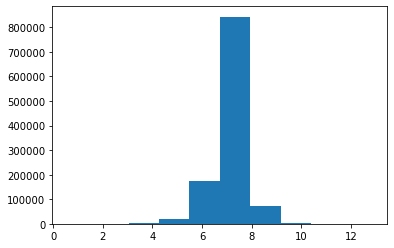

In [91]:
plt.hist(y_train_log)

In [92]:
gc.collect()

21

## 3.3 Entraînement du RN

In [101]:
input_shape = x_train.shape[1]

In [102]:
from keras.layers import Input, Dense, AlphaDropout, BatchNormalization, Concatenate
from keras.models import Model

inputs = Input(shape=(input_shape,))
from keras import regularizers
x1 = BatchNormalization()(inputs)
x = Dense(500, activation='selu', kernel_initializer="lecun_uniform", bias_initializer='lecun_uniform',
          kernel_regularizer=regularizers.l1(0.0000001))(x1)
x = Dense(100, activation='selu', kernel_initializer="lecun_uniform", bias_initializer='lecun_uniform')(x)
x = AlphaDropout(0.2)(x)
x = Dense(50, activation='selu', kernel_initializer="lecun_uniform", bias_initializer='lecun_uniform',
          kernel_regularizer=regularizers.l1(0.000001))(x)
x = Dense(20, activation='selu', kernel_initializer="lecun_uniform", bias_initializer='lecun_uniform',
          kernel_regularizer=regularizers.l1(0.000001))(x)
x = Dense(20, activation='selu', kernel_initializer="lecun_uniform", bias_initializer='lecun_uniform')(x)
x = Dense(8, activation='selu', kernel_initializer="lecun_uniform", bias_initializer='lecun_uniform')(x)
x = Dense(4, activation='selu', kernel_initializer="lecun_uniform", bias_initializer='lecun_uniform')(x)
x = Dense(2, activation='selu', kernel_initializer="lecun_uniform", bias_initializer='lecun_uniform')(x)
x = Concatenate(axis=1)([x, x1])
predictions = Dense(1, activation='linear', kernel_regularizer=regularizers.l1(0.00001))(x)

model1= Model(inputs=inputs, outputs=predictions)
model1.compile(optimizer=tf.keras.optimizers.Adagrad(0.1),
              loss='mse',
              metrics=['mse', 'mae'])

Le modèle est un peu particulier : la dernière couche caché rassemble l'output du RN proprement dit (incluant les non-linéarités composées) et les inputs, si bien que l'output du modèle total est une combinaison linéaire du RN et des inputs. Cela permet de reproduire rapidement les performances d'un modèle linéaire, et de concentrer l'entraînement du RN sur les gains prédictifs par rapport au modèle linéaire.

En pratique, on ne parvient pas à des meilleures performances plus élevées que pour un RN classique, mais l'entraînement est beaucoup plus stable.

Le modèle est entraîné en plusieurs étapes, en faisant varier le nombre d'époque et la taille de batch.

Si les deux premières époques n'aboutissent pas déjà à un résultat satisfaisant sur l'échantillon de validation (val_mse<0.3 par exemple) on peut reprendre la cellule précédente pour entraîner un nouveau modèle à partir de 0.

In [103]:
history = model1.fit(x_train, y_train_log, validation_split=0.1, batch_size=64, epochs=2, shuffle=False)
# starts training

Epoch 1/2
15663/15663 [==============================] - 72s 5ms/step - loss: 0.1845 - mse: 0.1829 - mae: 0.2688 - val_loss: 0.1540 - val_mse: 0.1524 - val_mae: 0.2446
Epoch 2/2
15663/15663 [==============================] - 71s 5ms/step - loss: 0.1403 - mse: 0.1388 - mae: 0.2363 - val_loss: 0.1434 - val_mse: 0.1418 - val_mae: 0.2355


In [104]:
hist_df = pd.DataFrame(history.history)

In [105]:
history = model1.fit(x_train, y_train_log, validation_split=0.1, batch_size=10000, epochs=2, shuffle=False)
# starts training

Epoch 1/2
101/101 [==============================] - 22s 216ms/step - loss: 0.1337 - mse: 0.1322 - mae: 0.2240 - val_loss: 0.1331 - val_mse: 0.1315 - val_mae: 0.2250
Epoch 2/2
101/101 [==============================] - 21s 205ms/step - loss: 0.1302 - mse: 0.1286 - mae: 0.2205 - val_loss: 0.1312 - val_mse: 0.1297 - val_mae: 0.2230


In [106]:
hist_df = pd.concat([hist_df, pd.DataFrame(history.history)], ignore_index=True) 

In [107]:
history = model1.fit(x_train, y_train_log, validation_split=0.1, batch_size=64, epochs=10, shuffle=False)
# continues training the same model

Epoch 1/10
15663/15663 [==============================] - 71s 5ms/step - loss: 0.1344 - mse: 0.1328 - mae: 0.2293 - val_loss: 0.1367 - val_mse: 0.1352 - val_mae: 0.2292
Epoch 2/10
15663/15663 [==============================] - 70s 4ms/step - loss: 0.1314 - mse: 0.1298 - mae: 0.2257 - val_loss: 0.1350 - val_mse: 0.1335 - val_mae: 0.2261
Epoch 3/10
15663/15663 [==============================] - 72s 5ms/step - loss: 0.1294 - mse: 0.1278 - mae: 0.2232 - val_loss: 0.1345 - val_mse: 0.1329 - val_mae: 0.2252
Epoch 4/10
15663/15663 [==============================] - 72s 5ms/step - loss: 0.1279 - mse: 0.1263 - mae: 0.2216 - val_loss: 0.1335 - val_mse: 0.1319 - val_mae: 0.2228
Epoch 5/10
15663/15663 [==============================] - 72s 5ms/step - loss: 0.1267 - mse: 0.1251 - mae: 0.2201 - val_loss: 0.1326 - val_mse: 0.1311 - val_mae: 0.2224
Epoch 6/10
15663/15663 [==============================] - 73s 5ms/step - loss: 0.1257 - mse: 0.1241 - mae: 0.2190 - val_loss: 0.1317 - val_mse: 0.1301 - va

In [108]:
hist_df = pd.concat([hist_df, pd.DataFrame(history.history)], ignore_index=True) 

In [109]:
history = model1.fit(x_train, y_train_log, validation_split=0.1, batch_size=10000, epochs=50, shuffle=False)
# continues training the same model

Epoch 1/50
101/101 [==============================] - 22s 217ms/step - loss: 0.1208 - mse: 0.1192 - mae: 0.2106 - val_loss: 0.1228 - val_mse: 0.1212 - val_mae: 0.2121
Epoch 2/50
101/101 [==============================] - 21s 210ms/step - loss: 0.1183 - mse: 0.1167 - mae: 0.2084 - val_loss: 0.1215 - val_mse: 0.1199 - val_mae: 0.2109
Epoch 3/50
101/101 [==============================] - 21s 210ms/step - loss: 0.1176 - mse: 0.1160 - mae: 0.2076 - val_loss: 0.1208 - val_mse: 0.1192 - val_mae: 0.2103
Epoch 4/50
101/101 [==============================] - 21s 210ms/step - loss: 0.1171 - mse: 0.1155 - mae: 0.2072 - val_loss: 0.1205 - val_mse: 0.1189 - val_mae: 0.2100
Epoch 5/50
101/101 [==============================] - 21s 210ms/step - loss: 0.1170 - mse: 0.1153 - mae: 0.2070 - val_loss: 0.1203 - val_mse: 0.1187 - val_mae: 0.2098
Epoch 6/50
101/101 [==============================] - 21s 211ms/step - loss: 0.1168 - mse: 0.1152 - mae: 0.2068 - val_loss: 0.1202 - val_mse: 0.1185 - val_mae: 0.209

In [110]:
hist_df = pd.concat([hist_df, pd.DataFrame(history.history)], ignore_index=True) 

In [111]:
history = model1.fit(x_train, y_train_log, validation_split=0.1, batch_size=1067, epochs=50, shuffle=True)
# continues training the same model

Epoch 1/50
940/940 [==============================] - 35s 37ms/step - loss: 0.1161 - mse: 0.1145 - mae: 0.2060 - val_loss: 0.1189 - val_mse: 0.1172 - val_mae: 0.2082
Epoch 2/50
940/940 [==============================] - 34s 37ms/step - loss: 0.1158 - mse: 0.1142 - mae: 0.2058 - val_loss: 0.1200 - val_mse: 0.1183 - val_mae: 0.2096
Epoch 3/50
940/940 [==============================] - 34s 37ms/step - loss: 0.1157 - mse: 0.1141 - mae: 0.2057 - val_loss: 0.1194 - val_mse: 0.1178 - val_mae: 0.2087
Epoch 4/50
940/940 [==============================] - 34s 37ms/step - loss: 0.1154 - mse: 0.1138 - mae: 0.2055 - val_loss: 0.1199 - val_mse: 0.1183 - val_mae: 0.2096
Epoch 5/50
940/940 [==============================] - 34s 37ms/step - loss: 0.1154 - mse: 0.1138 - mae: 0.2054 - val_loss: 0.1186 - val_mse: 0.1170 - val_mae: 0.2080
Epoch 6/50
940/940 [==============================] - 35s 37ms/step - loss: 0.1152 - mse: 0.1136 - mae: 0.2053 - val_loss: 0.1201 - val_mse: 0.1185 - val_mae: 0.2099
Epoc

In [112]:
hist_df = pd.concat([hist_df, pd.DataFrame(history.history)], ignore_index=True) 

In [113]:
history = model1.fit(x_train, y_train_log, validation_split=0.1, batch_size=10111, epochs=50, shuffle=False)
# continues training the same model

Epoch 1/50
100/100 [==============================] - 22s 218ms/step - loss: 0.1103 - mse: 0.1087 - mae: 0.2008 - val_loss: 0.1172 - val_mse: 0.1156 - val_mae: 0.2063
Epoch 2/50
100/100 [==============================] - 21s 211ms/step - loss: 0.1103 - mse: 0.1087 - mae: 0.2007 - val_loss: 0.1171 - val_mse: 0.1155 - val_mae: 0.2062
Epoch 3/50
100/100 [==============================] - 21s 211ms/step - loss: 0.1101 - mse: 0.1085 - mae: 0.2007 - val_loss: 0.1172 - val_mse: 0.1156 - val_mae: 0.2063
Epoch 4/50
100/100 [==============================] - 21s 211ms/step - loss: 0.1102 - mse: 0.1086 - mae: 0.2007 - val_loss: 0.1170 - val_mse: 0.1154 - val_mae: 0.2061
Epoch 5/50
100/100 [==============================] - 21s 211ms/step - loss: 0.1101 - mse: 0.1085 - mae: 0.2006 - val_loss: 0.1171 - val_mse: 0.1155 - val_mae: 0.2063
Epoch 6/50
100/100 [==============================] - 21s 210ms/step - loss: 0.1102 - mse: 0.1086 - mae: 0.2007 - val_loss: 0.1172 - val_mse: 0.1156 - val_mae: 0.206

In [114]:
hist_df = pd.concat([hist_df, pd.DataFrame(history.history)], ignore_index=True) 

## 3.4 Analyse et enregistrement du modèle

On analyse les résultat visuellement en faisant un graphique de la log-mse sur les échantillons d'entraînement et de validation. Pour qu'il soit plus lisible, on peut caler chaque courbe sur un minorant approximatif respectif.

In [118]:
min_train = 0.103
min_val = 0.11

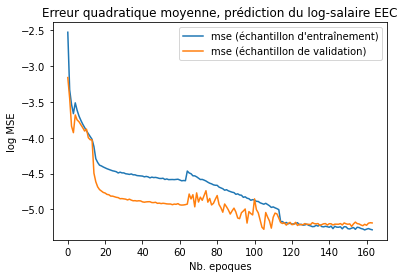

In [119]:
plt.plot(np.log(hist_df['mse']-min_train), label="mse (échantillon d'entraînement)")
plt.plot(np.log(hist_df['val_mse']-min_val), label="mse (échantillon de validation)")
plt.title('Erreur quadratique moyenne, prédiction du log-salaire EEC')
plt.ylabel('log MSE')
plt.xlabel('Nb. epoques')
plt.legend(loc="best")
plt.savefig('train_val_mse.png', bbox_inches='tight')

Si la performance sur l'échantillon de validation est bonne, on sauvegarde le modèle, son historique d'entraînement, et les noms des colonnes sélectionnées.

In [122]:
if history.history['val_mse'][-1] < 0.15:
    modelname = datetime.datetime.now().strftime("%I_%M%p_on_%B_%d_%Y")
    pathname = modelpath + modelname
    model1.save(pathname)
    print("Saved model to disk")
    print(pathname)
    history_pathname = modelpath + 'history/' + modelname + '.csv'
    hist_df.to_csv(history_pathname)
    print("Saved history to disk")
    print(history_pathname)
    traincol = pd.DataFrame(train_df.columns.drop(predicted))
    traincol_pathname = modelpath + 'traincol/' + modelname + '.csv'
    traincol.to_csv(traincol_pathname)
    print("Saved train columns to disk")
    print(traincol_pathname)

INFO:tensorflow:Assets written to: X:/HAB-deep-learning-pour-ssp/models/02_24PM_on_October_04_2022\assets


2022-10-04 14:24:39,629 : INFO : Assets written to: X:/HAB-deep-learning-pour-ssp/models/02_24PM_on_October_04_2022\assets


Saved model to disk
X:/HAB-deep-learning-pour-ssp/models/02_24PM_on_October_04_2022
Saved history to disk
X:/HAB-deep-learning-pour-ssp/models/history/02_24PM_on_October_04_2022.csv
Saved train columns to disk
X:/HAB-deep-learning-pour-ssp/models/traincol/02_24PM_on_October_04_2022.csv


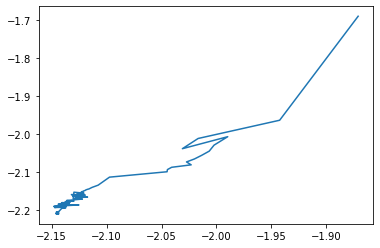

In [123]:
plt.plot(np.log(hist_df['val_loss']),np.log(hist_df['loss']))

In [1418]:
#plt.plot(hist_df['val_mse'],hist_df['val_exponential_mse'], 'bo',label='validation data')
#plt.plot(hist_df['mse'],hist_df['exponential_mse'], 'go',label='training data')
#plt.title('Log_wage loss and Wage loss')
#plt.ylabel('Wage MSE')
#plt.xlabel('Log-wage MSE')
#plt.legend(loc="best")

# 4. Evaluation sur l'échantillon test

Pour éviter de "tricher" (et risquer un surapprentissage invisible), on ne mobilise l'échantillon test qu'une seule fois, en fin de processus, le modèle étant déjà choisi et entraîné.

### Chargement d'un modèle

In [124]:
#smodel = tf.keras.models.load_model(modelpath+'11_07PM_on_March_28_2022')
smodel = model1

# Check its architecture
smodel.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 346)]        0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 346)          1384        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 500)          173500      batch_normalization[0][0]        
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          50100       dense[0][0]                      
_______________________________________________________________________________________

## 4.2 Estimation sur échantillon test

### Calcul du (pseudo-) R2 sur échantillon test

On définit une fonction d'estimation de la performance sur un échantillon

In [95]:
def perfestim(df, model, predvar):
    '''
    df: the sample on which the prediction performances are evaluated
    model: trained predictor to be evaluated
    predvar: the name of the column to predict in df
    '''
    x = df.drop(columns=[predvar])
    y = df.loc[:,[predvar]]
    y["log_SAL"] = np.log(y+1)
    y["log_SALPRED"] = model.predict(x)
    y["SALPRED"] = np.exp(y["log_SALPRED"])
    
    lvarsal = y["log_SAL"].var()
    lvarp = y["log_SALPRED"].var()
    lvarpred = (y["log_SAL"]-y["log_SALPRED"]).var()
    lR2 = 1 - (lvarpred/lvarsal)
    
    varsal = y[predvar].var()
    varp = y["SALPRED"].var()
    varpred = (y[predicted]-y["SALPRED"]).var()
    R2 = 1 - (varpred/varsal)
    
    results = {
        "Variance totale log-salaire": lvarsal,
        "Variance du prédicteur du log-salaire": lvarp,
        "Variance des résidus du log-salaire": lvarpred,
        "R2 log-salaire": lR2,
        "Variance totale salaire": varsal,
        "Variance du prédicteur du salaire": varp,
        "Variance des résidus du salaire": varpred,
        "R2 salaire": R2
    }
    
    return [y, results]

In [126]:
RNperf = perfestim(df=test_df, model=smodel, predvar=predicted)

In [127]:
print(RNperf[1])

{'Variance totale log-salaire': 0.4115341030046739, 'Variance du prédicteur du log-salaire': 0.3278769850730896, 'Variance des résidus du log-salaire': 0.11885775015141258, 'R2 log-salaire': 0.7111837165289248, 'Variance totale salaire': 2246984.6333126994, 'Variance du prédicteur du salaire': 547024.75, 'Variance des résidus du salaire': 1632906.992932268, 'R2 salaire': 0.2732896483920787}


On peut également regarder les performances sur des sous-échantillons tests: l'année 2018, le seul premier trimestre (test choisi pour le DT), ou seulement les personnes en première interrogation au premier trimestre 2018 (pour éviter toute "contamination" entre train et test par les réinterrogations)

In [128]:
RNperf18 = perfestim(df=test18_df, model=smodel, predvar=predicted)
RNperf18t1 = perfestim(df=test18_df.loc[test18_df.TRIM_1==1,], model=smodel, predvar=predicted)
RNperf18t1r1 = perfestim(df=test18_df.loc[(test18_df.TRIM_1==1)&(test18_df.RGA_1==1),], model=smodel, predvar=predicted)

In [129]:
print(RNperf18[1])
print(RNperf18t1[1])
print(RNperf18t1r1[1])

{'Variance totale log-salaire': 0.40021614820665274, 'Variance du prédicteur du log-salaire': 0.31670665740966797, 'Variance des résidus du log-salaire': 0.12557019881791212, 'R2 log-salaire': 0.6862440474214109, 'Variance totale salaire': 2664478.2905998337, 'Variance du prédicteur du salaire': 755989.9375, 'Variance des résidus du salaire': 1792878.4881361937, 'R2 salaire': 0.32711837268053834}
{'Variance totale log-salaire': 0.40804679088513135, 'Variance du prédicteur du log-salaire': 0.33126145601272583, 'Variance des résidus du log-salaire': 0.11581858671877336, 'R2 log-salaire': 0.7161634662839995, 'Variance totale salaire': 2206705.372688974, 'Variance du prédicteur du salaire': 792100.125, 'Variance des résidus du salaire': 1240731.62960884, 'R2 salaire': 0.43774477328754113}
{'Variance totale log-salaire': 0.40136757645660415, 'Variance du prédicteur du log-salaire': 0.33914390206336975, 'Variance des résidus du log-salaire': 0.10167172639230063, 'R2 log-salaire': 0.746686747

On conserve les prédictions, et on produit des graphiques pour visualiser les performances

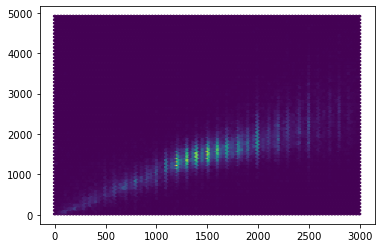

In [130]:
df18 = RNperf18[0]
plt.hexbin(df18.loc[(df18[predicted]<3000)&(df18["SALPRED"]<5000),predicted], 
           df18.loc[(df18[predicted]<3000)&(df18["SALPRED"]<5000),"SALPRED"])

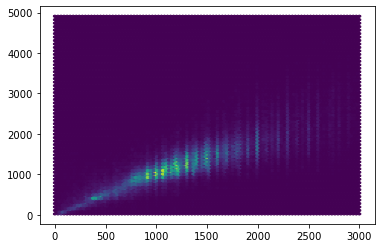

In [131]:
dfall = RNperf[0]
plt.hexbin(dfall.loc[(dfall[predicted]<3000)&(dfall["SALPRED"]<5000),predicted], 
           dfall.loc[(dfall[predicted]<3000)&(dfall["SALPRED"]<5000),"SALPRED"])

### Performance de prédiction par tranche

In [132]:
SALMEET = pd.cut(df18[predicted],bins=[0,499,999,1249,1499,1999,2499,2999,4999,7999,float("inf")])
SALPREDT = pd.cut(df18['SALPRED'],bins=[0,499,999,1249,1499,1999,2499,2999,4999,7999,float("inf")])

In [133]:
crosstab_RN_salmee = pd.crosstab(SALPREDT, SALMEET, normalize='columns')

On visualise la sous-représentation ou sur-représentation des prédictions dans certaines tranches, en fonction de la vraie tranche. Les salaires de la plus haute tranche (8000 euros et plus) sont clairement sous-estimés par le prédicteur, un biais déjà bien connu sur les modèles de salaire classiques.

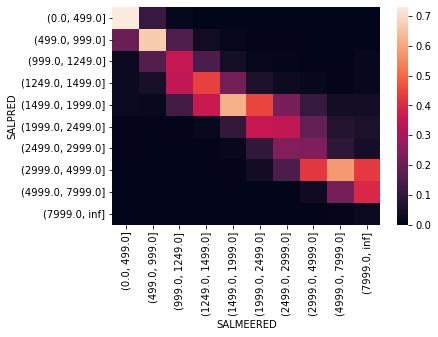

In [134]:
sn.heatmap(crosstab_RN_salmee)
plt.savefig('crosstab_RN_salmee.png', bbox_inches='tight')

### Expérimentation du redressement du biais de logarithme

On souhaite comparer prédictions et vraies valeurs sur certaines statistiques d'intérêt, qui portent en général sur les salaire en clair (et non en log). Cependant les modèles sont entraînés sur les log-salaires, ce qui peut induire un biais lorsqu'on revient au salaire. On essaye de corriger en multipliant les prédictions par l'exponentielle de la moitié de la variance des résidus du modèle en log. Cependant cette correction n'est valide que sous hypothèse de normalité des résidus.
On vérifie que cette hypothèse est loin de la réalité ici. 

Selon l'entraînement, cette correction fonctionne plus ou moins bien, et augmente ou diminue la performance prédictive du modèle. Nous ne l'appliquons pas par la suite.

In [135]:
t18 = pd.concat([x_test18,df18], axis=1)
tall = pd.concat([x_test,dfall], axis=1)

In [136]:
tall["logRESIDU"] = np.log(tall["SALMEERED"]) - np.log(tall["SALPRED"])

In [137]:
(tall["logRESIDU"]).mean()

0.026778701210260675

In [138]:
sigma2rn = (tall["logRESIDU"]).var()
sigma2rn

0.12363914976630347

<function matplotlib.pyplot.show(close=None, block=None)>

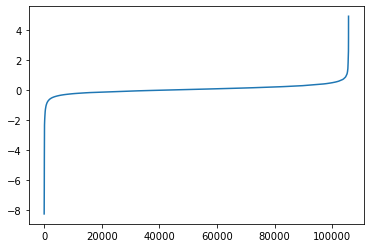

In [139]:
import scipy.stats as stats
residuals = sorted(tall["logRESIDU"])
normal_distribution = stats.norm.pdf(residuals, np.mean(residuals), np.std(residuals))
plt.plot(residuals)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

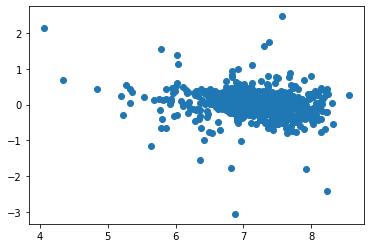

In [140]:
plt.scatter(np.log(tall.loc[1:10000,"SALPRED"]),tall.loc[1:10000,"logRESIDU"])

plt.show

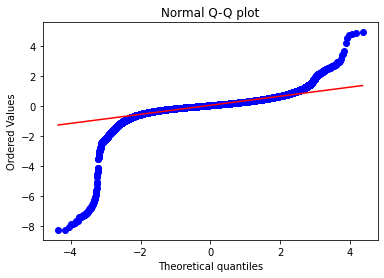

In [141]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [142]:
tall["SALPREDRED"] = tall["SALPRED"]*np.exp(sigma2rn/2)

In [143]:
tall["RESIDU"] = (tall["SALMEERED"]) - (tall["SALPRED"])

In [144]:
(tall["RESIDU"]).mean()

105.33800982890092

In [145]:
(tall["RESIDU"]).var()

1632906.992932268

In [146]:
tall["corRESIDU"] = (tall["SALMEERED"]) - (tall["SALPREDRED"])

In [147]:
(tall["corRESIDU"]).mean()

15.807187597737933

In [148]:
(tall["corRESIDU"]).var()

1630856.2913191437

### Statistiques d'intérêts sur salaires observés et imputés

In [149]:
#Moyenne et Moyennes annuelles
ma = tall.loc[:,('ANNEE','SALMEERED','SALPRED','SALPREDRED')].groupby('ANNEE').mean()
tall.loc[:,('SALMEERED','SALPRED','SALPREDRED')].mean()

SALMEERED     1509.293501
SALPRED       1403.959717
SALPREDRED    1493.483032
dtype: float64

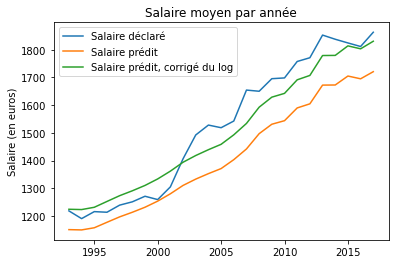

In [150]:
plt.plot(ma['SALMEERED'], label="Salaire déclaré")
plt.plot(ma['SALPRED'], label="Salaire prédit")
plt.plot(ma['SALPREDRED'], label="Salaire prédit, corrigé du log")
plt.title('Salaire moyen par année')
plt.ylabel('Salaire (en euros)')
plt.legend(loc="best")
plt.savefig('salaire_moyen_annuel.png', bbox_inches='tight')
plt.show()

In [151]:
#Moyenne par sexe
sx = tall.loc[:,('SEXE_1','SALMEERED','SALPRED','SALPREDRED')].groupby('SEXE_1').mean()
sx

,SALMEERED,SALPRED,SALPREDRED
SEXE_1,,,
0,1292.244325,1214.008423,1291.426270
1,1716.184363,1585.012573,1686.089478


## 4.3 Prédictions sur données manquantes avec réponses en tranches

Entre 2013 et 2019, le salaire déclaré par tranche répond à la même question (tranches identiques) et est codé par des valeurs de SALMET de 1 à 10.

On utilise le modèle pour prédire les salaires des enquêtés qui n'ont pas répondu en clair mais ont répondu en tranche. Il faut d'abord sélectionner cet échantillon et mettre en forme cette variable

In [106]:
salmetlist = ['SALMET_1','SALMET_2','SALMET_3','SALMET_4','SALMET_5','SALMET_6',
 'SALMET_7','SALMET_8','SALMET_9','SALMET_10']
keeplist = predl+salmetlist
misslist = [i for i in keeplist if i in complete_col_list]
miss_df = df.loc[(df["ANNEE"]>2012)&(df["ANNEE"]<2019)&(df["SALMET_new_nan"]==0)&(df["SALMEE_nan"]==1),misslist]
miss_df["SALMET"] = miss_df["SALMET_1"]+2*miss_df["SALMET_2"]+3*miss_df["SALMET_3"]+4*miss_df["SALMET_4"]+5*miss_df["SALMET_5"]+6*miss_df["SALMET_6"]+7*miss_df["SALMET_7"]+8*miss_df["SALMET_8"]+9*miss_df["SALMET_9"]+10*miss_df["SALMET_10"]

In [153]:
x_testm = miss_df.loc[:,predl]
dfm = miss_df.loc[:,["SALMET"]]
dfm["SALPRED"] = np.exp(smodel.predict(x_testm))
dfm = dfm.loc[dfm["SALMET"]!=0,:]
SALMET = dfm["SALMET"]
SALPREDT = pd.cut(dfm['SALPRED'],bins=[0,499,999,1249,1499,1999,2499,2999,4999,7999,float("inf")])
RN_tranches = pd.crosstab(SALPREDT,SALMET)

<AxesSubplot:xlabel='SALMET', ylabel='SALPRED'>

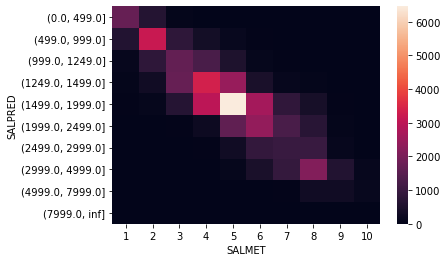

In [154]:
sn.heatmap(RN_tranches)

In [155]:
crosstab_RN_salmet = pd.crosstab(SALPREDT, SALMET, normalize='columns')

On visualise la sous-représentation ou la sur-représentation des prédictions par tranche en fonction de la vraie tranche, pour les enquêtés qui n'ont pas répondu pour leur salaire en clair. La structure ressemble à celle des enquêtés répondants de l'échantillon test, ce qui est rassurant et suggère que le modèle ne dérive pas lorsqu'il est confronté à de véritables non-répondants (en clair).

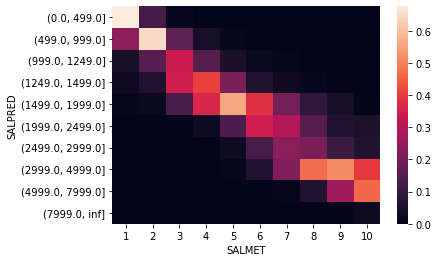

In [156]:
sn.heatmap(crosstab_RN_salmet)
plt.savefig('crosstab_RN_salmet.png', bbox_inches='tight')

On peut comparer directement ces erreurs de prédiction entre la population des répondants en clair (sur l'échantillon test) et la population des non-répondants en clair, mais répondants en tranche. Les écarts sont faibles, ce qui est rassurant, mais vont plutôt dans le sens d'une prédiction moins précise sur les véritables non-répondants.

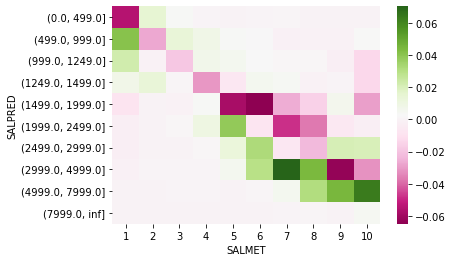

In [157]:
NR_diff = crosstab_RN_salmet.subtract(crosstab_RN_salmee.values, axis='index')
sn.heatmap(NR_diff, cmap="PiYG")
plt.savefig('crosstab_RN_diff.png', bbox_inches='tight')

# 5. Comparaisons

## 5.1 Comparaison avec un modèle linéaire sur l'ensemble des features du RN

On exploite directement les fichiers construits pour l'entraînement du RN

In [93]:
X = x_train
Y = y_train_log.values

OLSmodel = sm.OLS(Y, X).fit()
predictions = OLSmodel.predict(X)

OLSmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     7267.
Date:                Tue, 04 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:13:08   Log-Likelihood:            -5.3217e+05
No. Observations:             1113747   AIC:                         1.065e+06
Df Residuals:                 1113486   BIC:                         1.068e+06
Df Model:                         260                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
DDIPL                -0.0694      0.000   -194.535      0.000      -0.070      -0.069
NAIM                 -0.0005      0.000     -4.443      0.000      -0.001      -0.000
NAIA                 -0.0005      0.000     -2.056      0.040      -0.001   -2.39e-05
HH                    0.0272   7.58e-05    358.524      0.000       0.027       0.027
HT                    0.0020   4.29e-05     45.845      0.000       0.002       0.002
CSE                  -0.0149   6.65e-05   -224.686      0.000      -0.015      -0.015
ANNEE                 0.0085      0.000     16.966      0.000       0.007       0.009
EMPNBH                0.0034   7.48e-05     45.836      0.000       0.003       0.004
DATANT                0.0048      0.001      6.817      0.000       0.003       0.006
DAMOIS               -0.0005      0.000     -3.632      0.000      -0.001      -0.000
NRESID                0.0011      0.000      7.780      0.000       0.001       0.001
HATYEAR               0.0018   8.42e-05     21.012      0.000       0.002       0.002
NBINDE                0.0005      0.001      0.380      0.704      -0.002       0.003
NBACTOC              -0.0082      0.002     -4.725      0.000      -0.012      -0.005
NBENF18A              0.0126      0.001      8.702      0.000       0.010       0.015
NBENF6A               0.0057      0.002      2.777      0.005       0.002       0.010
NBENF3A               0.0107      0.004      2.868      0.004       0.003       0.018
NBENF18MA            -0.0098      0.004     -2.394      0.017      -0.018      -0.002
HHC                  -0.0134      0.000    -96.320      0.000      -0.014      -0.013
NBCHOME              -0.0101      0.002     -5.048      0.000      -0.014      -0.006
DATDIP               -0.0013      0.000     -9.775      0.000      -0.002      -0.001
NBTOT                 0.0009      0.000      3.188      0.001       0.000       0.001
CSPP                 -0.0001   3.75e-05     -3.597      0.000      -0.000   -6.13e-05
CSPM                  0.0001   3.18e-05      3.989      0.000    6.45e-05       0.000
FORDAT               -0.0081      0.001    -12.206      0.000      -0.009      -0.007
DIPDET                0.0060      0.000     31.525      0.000       0.006       0.006
NBACTOP              -0.0058      0.002     -3.861      0.000      -0.009      -0.003
NBACTIF              -0.0160      0.002     -8.580      0.000      -0.020      -0.012
NBENFIND              0.0230      0.002     12.855      0.000       0.019       0.026
NBENFA18             -0.0107      0.003     -3.672      0.000      -0.016      -0.005
NBENFA15              0.0024      0.003      0.846      0.398      -0.003       0.008
NBENFA10              0.0005      0.003      0.200      0.841      -0.005       0.006
NBENFA6              -0.0020      0.003     -0.632      0.527      -0.008

On estime les performances de ce modèle linéaire sur les différents échantillons test

In [96]:
OLSperf = perfestim(df=test_df, model=OLSmodel, predvar=predicted)

In [97]:
print(OLSperf[1])

{'Variance totale log-salaire': 0.4115341030046739, 'Variance du prédicteur du log-salaire': 0.2545616494441364, 'Variance des résidus du log-salaire': 0.15487313749749906, 'R2 log-salaire': 0.6236687643460253, 'Variance totale salaire': 2246984.6333126994, 'Variance du prédicteur du salaire': 505714.02261606074, 'Variance des résidus du salaire': 1724675.410571853, 'R2 salaire': 0.23244895180738867}


In [98]:
ols_df = OLSperf[0]

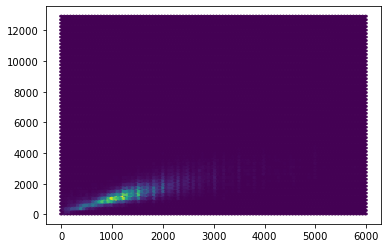

In [99]:
plt.hexbin(ols_df.loc[ols_df[predicted]<6000,predicted], ols_df.loc[ols_df[predicted]<6000,"SALPRED"])

In [101]:
OLSperf18 = perfestim(df=test18_df, model=OLSmodel, predvar=predicted)
OLSperf18t1 = perfestim(df=test18_df.loc[test18_df.TRIM_1==1,], model=OLSmodel, predvar=predicted)
OLSperf18t1r1 = perfestim(df=test18_df.loc[(test18_df.TRIM_1==1)&(test18_df.RGA_1==1),], model=OLSmodel, predvar=predicted)

In [102]:
print(OLSperf18[1])
print(OLSperf18t1[1])
print(OLSperf18t1r1[1])

{'Variance totale log-salaire': 0.40021614820665274, 'Variance du prédicteur du log-salaire': 0.27324865162559825, 'Variance des résidus du log-salaire': 0.14424863645328082, 'R2 log-salaire': 0.6395731728975673, 'Variance totale salaire': 2664478.2905998337, 'Variance du prédicteur du salaire': 653106.3189686481, 'Variance des résidus du salaire': 1898242.0029435405, 'R2 salaire': 0.28757460338841656}
{'Variance totale log-salaire': 0.40804679088513135, 'Variance du prédicteur du log-salaire': 0.28116953306052694, 'Variance des résidus du log-salaire': 0.13790644174070923, 'R2 log-salaire': 0.6620327746198815, 'Variance totale salaire': 2206705.372688974, 'Variance du prédicteur du salaire': 667081.9407937265, 'Variance des résidus du salaire': 1376219.3022167399, 'R2 salaire': 0.3763466028363577}
{'Variance totale log-salaire': 0.40136757645660415, 'Variance du prédicteur du log-salaire': 0.2910952257362159, 'Variance des résidus du log-salaire': 0.12625644188681698, 'R2 log-salaire'

In [103]:
ols_df18 = OLSperf18[0]

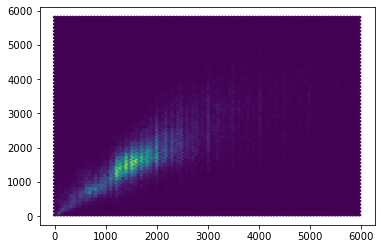

In [104]:
plt.hexbin(ols_df18.loc[ols_df18[predicted]<6000,predicted], ols_df18.loc[ols_df18[predicted]<6000,"SALPRED"])

On compare les prédictions par tranche sur la population des non-répondants en clair mais répondants en tranche, pour le modèle OLS et pour le modèle RN

In [107]:
x_testm = miss_df.loc[:,predl]
dfo = miss_df.loc[:,["SALMET"]]
dfo["SALPRED"] = np.exp(OLSmodel.predict(x_testm))
dfo = dfo.loc[dfo["SALMET"]!=0,:]
SALMETols = dfo["SALMET"]
SALPREDTols = pd.cut(dfo['SALPRED'],bins=[0,499,999,1249,1499,1999,2499,2999,4999,7999,float("inf")])
ols_tranches = pd.crosstab(SALPREDTols, SALMETols,  normalize='columns', dropna=False)

In [ ]:
RN_ols_diff = ols_tranches.subtract(crosstab_RN_salmet.values, axis='index')

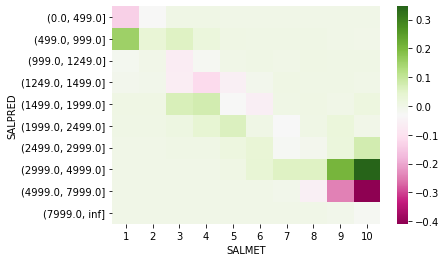

In [174]:
sn.heatmap(RN_ols_diff, cmap="PiYG")
plt.savefig('RN_ols_diff', bbox_inches='tight')

On distingue nettement la forte différence d'erreur de prédiction pour les hauts salaires : les enquêtés ayant déclaré, en tranche, gagner plus de 8000 euros par mois ont une tranche de salaire bien mieux prédite par le modèle RN que par le modèle OLS. Les non-linéarités du RN réduisent donc le biais de prédiction sur les hauts salaires.

## 5.2 Comparaison avec des modèles linéaires avec des jeux de variable différents

La sélection des variables se fait avant les étapes de retraitements des valeurs manquantes et de vectorisation. On doit donc reprendre une partie de ces retraitements après sélection des variables.

### Mincer sans les nomenclatures (sauf le secteur en trois chiffres)

In [109]:
# Mincer sans nomenclatures
madata = copy.deepcopy(datasave2.loc[:,Mincercola])
print(madata.shape)
madata.loc[:,"SECT"] = [i[0:2] for i in madata.loc[:,"SECT"].astype("str")]
objl = [i for i in madata.columns if (i not in numl)]
objl = objl+['CSE','DDIPL','SECT']
numl = [i for i in madata.columns if (i not in objl)]
madata_nonan = replace_nans(madata, numl, objl)
#num_cols = get_cols(madata_nonan , 'num')
#cat_cols = get_cols(madata_nonan , 'no_num')
print(madata_nonan.shape)
print('There were {} columns before encoding categorical features'.format(madata_nonan.shape[1]))
Mincera = oneHotEncode(madata_nonan, objl)
print('There are {} columns after encoding categorical features'.format(Mincera.shape[1]))

(1531841, 36)
replacing nan in...
numerical column...
NAIM
NAIA
ANNEE
LHHC
DATANT
DAMOIS
DATDIP
NBTOT
FORDAT
AGE
EXPE
EXPEPOT
SALMEERED
categorical column...
STATUT
CSE
DDIPL
SEXE
ACTEU
RGA
PRIM
PRIMS
REVENT
AUTSAL
TYPSAL
AM2NB
CHPUB
CONTRA
FONCTC
TITC
TPP
OCCREF
QPRC
TPPRED
IMMI
SECT
TRIM
(1531841, 46)
There were 46 columns before encoding categorical features
OneHotEncoding column...
STATUT
CSE
DDIPL
SEXE
ACTEU
RGA
PRIM
PRIMS
REVENT
AUTSAL
TYPSAL
AM2NB
CHPUB
CONTRA
FONCTC
TITC
TPP
OCCREF
QPRC
TPPRED
IMMI
SECT
TRIM
There are 273 columns after encoding categorical features


In [110]:
del(madata)
del(madata_nonan)
gc.collect()

45

In [111]:
Mincera[['SALMET']] = datasave2.loc[:,['SALMET']]
Mincera[['CONSTANT']]=1
Mincera[['AGE2']]=Mincera[['AGE']]*Mincera[['AGE']]

In [112]:
mdata= Mincera.loc[Mincera["SALMEERED_nan"]==0,:].drop(columns=["SALMET"])

In [113]:
mtrain = mdata.loc[(mdata["NAIM"]!=3)&(mdata["ANNEE"]<2018),:]
my_train = mtrain.loc[:,"SALMEERED"].values
mx_train = mtrain.drop(columns=["SALMEERED"])
mtest = mdata.loc[(mdata["NAIM"]==3)|(mdata["ANNEE"]==2018),:]
mtest18 = mdata.loc[mdata["ANNEE"]==2018,:]
mylog_train = np.log(my_train+1)

In [114]:
X = mx_train
Y = mylog_train

MINCERmodel = sm.OLS(Y, X).fit()
predictions = MINCERmodel.predict(X)

MINCERmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     7436.
Date:                Tue, 04 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:17:59   Log-Likelihood:            -6.0515e+05
No. Observations:             1114668   AIC:                         1.211e+06
Df Residuals:                 1114426   BIC:                         1.214e+06
Df Model:                         241                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
NAIM              -0.0003      0.000     -2.588      0.010      -0.001   -7.27e-05
NAIA              -0.0084      0.000    -30.051      0.000      -0.009      -0.008
ANNEE              0.0180      0.001     33.702      0.000       0.017       0.019
LHHC               0.6075      0.002    302.290      0.000       0.604       0.611
DATANT             0.0037      0.001      5.001      0.000       0.002       0.005
DAMOIS            -0.0007      0.000     -5.119      0.000      -0.001      -0.000
DATDIP            -0.0024      0.000    -17.161      0.000      -0.003      -0.002
NBTOT              0.0028      0.000      9.848      0.000       0.002       0.003
FORDAT            -0.0059      0.001     -8.480      0.000      -0.007      -0.005
AGE                0.0264      0.000     81.923      0.000       0.026       0.027
EXPE               0.0037      0.001      4.995      0.000       0.002       0.005
EXPEPOT           -0.0089      0.001    -13.022      0.000      -0.010      -0.008
NAIM_nan          -0.0413      0.020     -2.052      0.040      -0.081      -0.002
LHHC_nan           3.1801      0.017    183.794      0.000       3.146       3.214
DATANT_nan         7.2968      1.462      4.990      0.000       4.431      10.163
DAMOIS_nan         0.0425      0.002     28.085      0.000       0.040       0.045
DATDIP_nan        -0.0234      0.007     -3.317      0.001      -0.037      -0.010
NBTOT_nan          0.1508      0.012     12.811      0.000       0.128       0.174
FORDAT_nan        -0.3135      0.025    -12.545      0.000      -0.362      -0.264
EXPE_nan           7.2968      1.462      4.990      0.000       4.431      10.163
EXPEPOT_nan       -0.3135      0.025    -12.545      0.000      -0.362      -0.264
SALMEERED_nan  -5.574e-13   9.43e-14     -5.914      0.000   -7.42e-13   -3.73e-13
STATUT_11          0.0534      0.026      2.040      0.041       0.002       0.105
STATUT_12          0.2999      0.026     11.532      0.000       0.249       0.351
STATUT_13         -0.2666      0.061     -4.377      0.000      -0.386      -0.147
STATUT_21          0.0016      0.023      0.069      0.945      -0.044       0.047
STATUT_22         -0.3927      0.023    -16.800      0.000      -0.439      -0.347
STATUT_33         -0.0983      0.023     -4.245      0.000      -0.144      -0.053
STATUT_34         -0.3542      0.023    -15.238      0.000      -0.400      -0.309
STATUT_35          0.0174      0.023      0.755      0.450      -0.028       0.063
STATUT_41          0.1100      0.023      4.751      0.000       0.065       0.155
STATUT_42         -0.5054      0.032    -15.925      0.000      -0.568      -0.443
STATUT_43         -0.1220      0.023     -5.230      0.000      -0.168      -0.076
STATUT_44         -0.1034      0.024     -4.315      0.000      -0.150      -0.056
STATUT_45   

{'Variance totale log-salaire': 0.4465930369100526, 'Variance du prédicteur du log-salaire': 0.28957362207762777, 'Variance des résidus du log-salaire': 0.1646581367612104, 'R2 log-salaire': 0.6313016031318601, 'Variance totale salaire': 2408042.0678540873, 'Variance du prédicteur du salaire': 615996.2365867645, 'Variance des résidus du salaire': 1746597.2804101494, 'R2 salaire': 0.27468157482538524}
{'Variance totale log-salaire': 0.40021614820665274, 'Variance du prédicteur du log-salaire': 0.27570212528644983, 'Variance des résidus du log-salaire': 0.1462879709281502, 'R2 log-salaire': 0.6344775902130415, 'Variance totale salaire': 2664478.2905998337, 'Variance du prédicteur du salaire': 720374.4045406705, 'Variance des résidus du salaire': 1903472.2679241125, 'R2 salaire': 0.28561164313498755}
{'Variance totale log-salaire': 0.40804679088513135, 'Variance du prédicteur du log-salaire': 0.28141855120010784, 'Variance des résidus du log-salaire': 0.14089584436603664, 'R2 log-salaire'

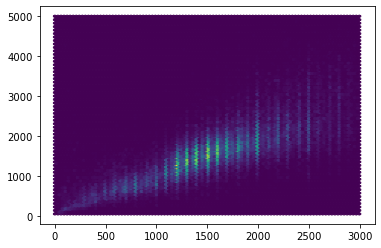

In [115]:
MINCERperf = perfestim(df=mtest, model=MINCERmodel, predvar=predicted)
print(MINCERperf[1])
MINCERperf18 = perfestim(df=mtest18, model=MINCERmodel, predvar=predicted)
MINCERperf18t1 = perfestim(df=mtest18.loc[mtest18.TRIM_1==1,], model=MINCERmodel, predvar=predicted)
MINCERperf18t1r1 = perfestim(df=mtest18.loc[(mtest18.TRIM_1==1)&(mtest18.RGA_1==1),], model=MINCERmodel, predvar=predicted)
print(MINCERperf18[1])
print(MINCERperf18t1[1])
print(MINCERperf18t1r1[1])
df18 = MINCERperf18[0]
plt.hexbin(df18.loc[(df18[predicted]<3000)&(df18["SALPRED"]<5000),predicted], 
           df18.loc[(df18[predicted]<3000)&(df18["SALPRED"]<5000),"SALPRED"])

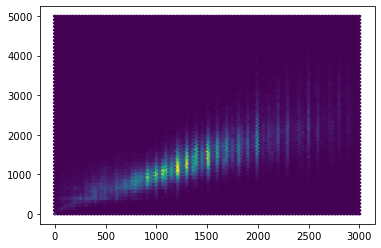

In [116]:
dfall = MINCERperf[0]
plt.hexbin(dfall.loc[(dfall[predicted]<3000)&(dfall["SALPRED"]<5000),predicted], 
           dfall.loc[(dfall[predicted]<3000)&(dfall["SALPRED"]<5000),"SALPRED"])

In [117]:
miss_df = Mincera.loc[(Mincera["ANNEE"]>2012)&(Mincera["ANNEE"]<2019)&(pd.notnull(Mincera["SALMET"]))&(Mincera["SALMEERED_nan"]==1),:]
miss_df = miss_df.loc[(miss_df['SALMET']!='98')&(miss_df['SALMET']!='99')&(miss_df['SALMET']!='0'),:]

In [119]:
traincolumns = mx_train.columns
x_testm = miss_df.loc[:,traincolumns]
dfm = miss_df.loc[:,["SALMET"]]
dfm["SALPRED"] = np.exp(MINCERmodel.predict(x_testm))
dfm = dfm.loc[dfm["SALMET"]!=0,:]
SALMET = dfm["SALMET"]
SALPREDT = pd.cut(dfm['SALPRED'],bins=[0,499,999,1249,1499,1999,2499,2999,4999,7999,float("inf")])
Mincera_tranches = pd.crosstab(SALPREDT,SALMET, normalize='columns', dropna=False)
tranches = ['1','2','3','4','5','6','7','8','9','10']
Mincera_tranches = Mincera_tranches.reindex(tranches, axis="columns")

In [255]:
RN_mincera_diff = Mincera_tranches.subtract(crosstab_RN_salmet.values, axis='index')

<AxesSubplot:xlabel='SALMET', ylabel='SALPRED'>

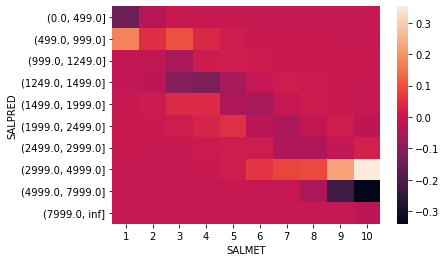

In [256]:
sn.heatmap(RN_mincera_diff)

In [120]:
del(Mincera)
del(mdata)
gc.collect()

29

#### Mincer avec les nomenclatures non vectorisées

In [121]:
# Mincer avec nomenclatures
mbdata = copy.deepcopy(datasave2.loc[:,Mincercolb])
print(mbdata.shape)
objl = [i for i in mbdata.columns if (i not in numl)]
objl = objl+['CSE','DDIPL','SECT','DIPDET','CSPP','CSPM']
mbdata_nonan = replace_nans(mbdata, numl, objl)
print(mbdata_nonan.shape)
print('There were {} columns before encoding categorical features'.format(mbdata_nonan.shape[1]))
Mincerb = oneHotEncode(mbdata_nonan, objl)
print('There are {} columns after encoding categorical features'.format(Mincerb.shape[1]))

(1531841, 45)
replacing nan in...
numerical column...
NAIM
NAIA
ANNEE
LHHC
DATANT
DAMOIS
DATDIP
NBTOT
FORDAT
AGE
EXPE
EXPEPOT
SALMEERED
categorical column...
STATUT
CSE
DDIPL
SEXE
ACTEU
RGA
CSPP
PRIM
PRIMS
REVENT
DNAI
AUTSAL
TYPSAL
AM2NB
CHPUB
CONTRA
FONCTC
TITC
TPP
OCCREF
CSPM
QPRC
TPPRED
IMMI
DIPDET
SECT
P
NAFN
DEP
DEPPER
DEPMER
TRIM
(1531841, 55)
There were 55 columns before encoding categorical features
OneHotEncoding column...
STATUT
CSE
DDIPL
SEXE
ACTEU
RGA
CSPP
PRIM
PRIMS
REVENT
DNAI
AUTSAL
TYPSAL
AM2NB
CHPUB
CONTRA
FONCTC
TITC
TPP
OCCREF
CSPM
QPRC
TPPRED
IMMI
DIPDET
SECT
P
NAFN
DEP
DEPPER
DEPMER
TRIM
There are 3761 columns after encoding categorical features


In [122]:
del(mbdata)
del(mbdata_nonan)
gc.collect()

21

In [123]:
Mincerb[['SALMET']] = datasave2.loc[:,['SALMET']]
Mincerb[['CONSTANT']]=1
Mincerb[['AGE2']]=Mincerb[['AGE']]*Mincerb[['AGE']]

In [124]:
mbdata= Mincerb.loc[Mincerb["SALMEERED_nan"]==0,:].drop(columns=["SALMET"])

In [125]:
mtrain = mbdata.loc[(mbdata["NAIM"]!=3)&(mbdata["ANNEE"]<2018),:]
my_train = mtrain.loc[:,"SALMEERED"].values
mx_train = mtrain.drop(columns=["SALMEERED"])
mtest = mbdata.loc[(mbdata["NAIM"]==3)|(mbdata["ANNEE"]==2018),:]
test18 = mbdata.loc[mbdata["ANNEE"]==2018,:]
mylog_train = np.log(my_train+1)

Le modèle linéaire avec les nomenclatures encodées en "one-hot" est trop gros pour être estimé:

In [376]:
X = mx_train
Y = mylog_train

mbmodel = sm.OLS(Y, X).fit()
predictions = mbmodel.predict(X)

mbmodel.summary()

MemoryError: Unable to allocate 31.2 GiB for an array with shape (3762, 1114668) and data type float64

In [ ]:
mbperf = perfestim(df=mtest, model=mbmodel, predvar=predicted)
print(mbperf[1])
mbperf18 = perfestim(df=mtest18, model=mbmodel, predvar=predicted)
mbperf18t1 = perfestim(df=mtest18.loc[mtest18.TRIM_1==1,], model=mbmodel, predvar=predicted)
mbperf18t1r1 = perfestim(df=mtest18.loc[(mtest18.TRIM_1==1)&(mtest18.RGA_1==1),], model=mbmodel, predvar=predicted)
print(mbperf18[1])
print(mbperf18t1[1])
print(mbperf18t1r1[1])
df18 = mbperf18[0]
plt.hexbin(df18.loc[(df18[predicted]<3000)&(df18["SALPRED"]<5000),predicted], 
           df18.loc[(df18[predicted]<3000)&(df18["SALPRED"]<5000),"SALPRED"])

In [126]:
del(Mincerb)
del(mbdata)
gc.collect()

84

#### Mincer "simple"

In [127]:
# Mincer avec variables type SALRED
mcdata = copy.deepcopy(datasave2.loc[:,Mincercolc])
print(mcdata.shape)
objl = [i for i in mcdata.columns if (i not in numl)]

mcdata_nonan = replace_nans(mcdata, numl, objl)
print(mcdata_nonan.shape)
print('There were {} columns before encoding categorical features'.format(mcdata_nonan.shape[1]))
Mincerc = oneHotEncode(mcdata_nonan, objl)
print('There are {} columns after encoding categorical features'.format(Mincerc.shape[1]))

(1531841, 32)
replacing nan in...
numerical column...
NAIM
NAIA
ANNEE
LHHC
DATDIP
NBTOT
FORDAT
AGE
EXPE
EXPEPOT
SALMEERED
categorical column...
STATUT
CSE
DDIPL
SEXE
ACTEU
RGA
PRIM
PRIMS
AUTSAL
TYPSAL
AM2NB
CHPUB
CONTRA
FONCTC
TITC
TPP
OCCREF
QPRC
TPPRED
SECT
TRIM
(1531841, 40)
There were 40 columns before encoding categorical features
OneHotEncoding column...
STATUT
CSE
DDIPL
SEXE
ACTEU
RGA
PRIM
PRIMS
AUTSAL
TYPSAL
AM2NB
CHPUB
CONTRA
FONCTC
TITC
TPP
OCCREF
QPRC
TPPRED
SECT
TRIM
There are 612 columns after encoding categorical features


In [128]:
del(mcdata)
del(mcdata_nonan)
gc.collect()

21

In [129]:
Mincerc[['SALMET']] = datasave2.loc[:,['SALMET']]
Mincerc[['CONSTANT']]=1
Mincerc[['AGE2']]=Mincerc[['AGE']]*Mincerc[['AGE']]

In [130]:
mcdata= Mincerc.loc[Mincerc["SALMEERED_nan"]==0,:].drop(columns=["SALMET"])

In [131]:
mtrain = mcdata.loc[(mcdata["NAIM"]!=3)&(mcdata["ANNEE"]<2018),:]
my_train = mtrain.loc[:,"SALMEERED"].values
mx_train = mtrain.drop(columns=["SALMEERED"])
mtest = mcdata.loc[(mcdata["NAIM"]==3)|(mcdata["ANNEE"]==2018),:]
mtest18 = mcdata.loc[mcdata["ANNEE"]==2018,:]
mylog_train = np.log(my_train+1)

In [132]:
X = mx_train
Y = mylog_train

mcmodel = sm.OLS(Y, X).fit()
predictions = mcmodel.predict(X)

mcmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     3135.
Date:                Tue, 04 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:39:12   Log-Likelihood:            -5.9827e+05
No. Observations:             1114668   AIC:                         1.198e+06
Df Residuals:                 1114084   BIC:                         1.205e+06
Df Model:                         583                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
NAIM              -0.0004      0.000     -3.058      0.002      -0.001      -0.000
NAIA              -0.0074      0.000    -56.793      0.000      -0.008      -0.007
ANNEE              0.0213      0.000    103.809      0.000       0.021       0.022
LHHC               0.6095      0.002    304.887      0.000       0.606       0.613
DATDIP            -0.0024      0.000    -17.402      0.000      -0.003      -0.002
NBTOT              0.0029      0.000     10.107      0.000       0.002       0.003
FORDAT            -0.0066      0.001     -9.518      0.000      -0.008      -0.005
AGE                0.0287      0.000    140.877      0.000       0.028       0.029
EXPE           -3.511e-06   9.92e-07     -3.539      0.000   -5.46e-06   -1.57e-06
EXPEPOT           -0.0094      0.001    -13.844      0.000      -0.011      -0.008
NAIM_nan          -0.0396      0.020     -1.977      0.048      -0.079      -0.000
LHHC_nan           3.1938      0.017    185.831      0.000       3.160       3.227
DATDIP_nan        -0.0317      0.007     -4.515      0.000      -0.045      -0.018
NBTOT_nan          0.1510      0.012     12.878      0.000       0.128       0.174
FORDAT_nan        -0.3359      0.025    -13.517      0.000      -0.385      -0.287
EXPE_nan          -0.0089      0.005     -1.672      0.094      -0.019       0.002
EXPEPOT_nan       -0.3359      0.025    -13.517      0.000      -0.385      -0.287
SALMEERED_nan   1.174e-13   2.54e-14      4.614      0.000    6.76e-14    1.67e-13
STATUT_11          0.0202      0.027      0.755      0.450      -0.032       0.073
STATUT_12          0.2609      0.027      9.810      0.000       0.209       0.313
STATUT_13         -0.2641      0.061     -4.337      0.000      -0.383      -0.145
STATUT_21          0.0186      0.024      0.770      0.442      -0.029       0.066
STATUT_22         -0.3906      0.024    -16.190      0.000      -0.438      -0.343
STATUT_33         -0.0878      0.024     -3.669      0.000      -0.135      -0.041
STATUT_34         -0.3310      0.024    -13.788      0.000      -0.378      -0.284
STATUT_35          0.0306      0.024      1.281      0.200      -0.016       0.077
STATUT_41          0.1162      0.024      4.860      0.000       0.069       0.163
STATUT_42         -0.5769      0.032    -18.080      0.000      -0.639      -0.514
STATUT_43         -0.1171      0.024     -4.863      0.000      -0.164      -0.070
STATUT_44         -0.1049      0.025     -4.249      0.000      -0.153      -0.056
STATUT_45          0.0681      0.024      2.850      0.004       0.021       0.115
STATUT_new_nan     0.2172      0.199      1.093      0.274      -0.172       0.607
CSE_00             0.0564      0.026      2.156      0.031       0.005       0.108
CSE_11            -0.2609      0.041     -6.424      0.000      -0.341      -0.181
CSE_12      

{'Variance totale log-salaire': 0.4465930369100526, 'Variance du prédicteur du log-salaire': 0.2903118586477443, 'Variance des résidus du log-salaire': 0.16282449369718432, 'R2 log-salaire': 0.6354074509899301, 'Variance totale salaire': 2408042.0678540873, 'Variance du prédicteur du salaire': 615615.6863518762, 'Variance des résidus du salaire': 1739251.6822185977, 'R2 salaire': 0.27773201912185785}
{'Variance totale log-salaire': 0.40021614820665274, 'Variance du prédicteur du log-salaire': 0.27332341520320613, 'Variance des résidus du log-salaire': 0.14483828571777987, 'R2 log-salaire': 0.6380998458788019, 'Variance totale salaire': 2664478.2905998337, 'Variance du prédicteur du salaire': 718165.12170917, 'Variance des résidus du salaire': 1894081.2280938276, 'R2 salaire': 0.28913617544715386}
{'Variance totale log-salaire': 0.40804679088513135, 'Variance du prédicteur du log-salaire': 0.27962247970249615, 'Variance des résidus du log-salaire': 0.13901404259236066, 'R2 log-salaire':

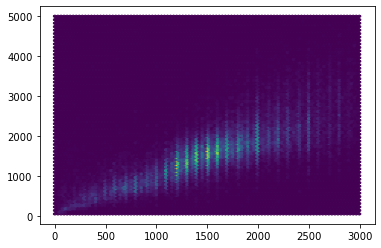

In [133]:
mcperf = perfestim(df=mtest, model=mcmodel, predvar=predicted)
print(mcperf[1])
mcperf18 = perfestim(df=mtest18, model=mcmodel, predvar=predicted)
mcperf18t1 = perfestim(df=mtest18.loc[mtest18.TRIM_1==1,], model=mcmodel, predvar=predicted)
mcperf18t1r1 = perfestim(df=mtest18.loc[(mtest18.TRIM_1==1)&(mtest18.RGA_1==1),], model=mcmodel, predvar=predicted)
print(mcperf18[1])
print(mcperf18t1[1])
print(mcperf18t1r1[1])
df18 = mcperf18[0]
plt.hexbin(df18.loc[(df18[predicted]<3000)&(df18["SALPRED"]<5000),predicted], 
           df18.loc[(df18[predicted]<3000)&(df18["SALPRED"]<5000),"SALPRED"])

In [134]:
del(Mincerc)
del(mcdata)
gc.collect()

21

#### Mincer "léger"

In [135]:
Mincercold = ['NAIM','ANNEE','LHHC','AGE','EXPEPOT','SALMEERED','DDIPL','TRIM','RGA']

In [136]:
# Mincer avec variables type SALRED
mddata = copy.deepcopy(datasave2.loc[:,Mincercold])
print(mddata.shape)
objl = [i for i in mddata.columns if (i not in numl)]
objl = objl+['DDIPL']
mddata_nonan = replace_nans(mddata, numl, objl)
print(mddata_nonan.shape)
print('There were {} columns before encoding categorical features'.format(mddata_nonan.shape[1]))
Mincerd = oneHotEncode(mddata_nonan, objl)
print('There are {} columns after encoding categorical features'.format(Mincerd.shape[1]))

(1531841, 9)
replacing nan in...
numerical column...
NAIM
ANNEE
LHHC
AGE
EXPEPOT
SALMEERED
categorical column...
DDIPL
TRIM
RGA
(1531841, 13)
There were 13 columns before encoding categorical features
OneHotEncoding column...
DDIPL
TRIM
RGA
There are 29 columns after encoding categorical features


In [137]:
del(mddata)
del(mddata_nonan)
gc.collect()

21

In [138]:
Mincerd[['SALMET']] = datasave2.loc[:,['SALMET']]
Mincerd[['CONSTANT']]=1
Mincerd[['AGE2']]=Mincerd[['AGE']]*Mincerd[['AGE']]

mddata= Mincerd.loc[Mincerd["SALMEERED_nan"]==0,:].drop(columns=["SALMET"])

In [139]:
traincols = [i for i in mddata.columns if (i not in ["SALMEERED",'NAIM','NAIM_nan','TRIM_1','TRIM_2','TRIM_3','TRIM_4',
                                                     'TRIM_new_nan','RGA_1','RGA_2','RGA_3','RGA_4','RGA_5','RGA_6',
                                                     'RGA_new_nan'])]

In [141]:
mtrain = mddata.loc[(mddata["NAIM"]!=3)&(mddata["ANNEE"]<2018),:]
my_train = mtrain.loc[:,"SALMEERED"]
mx_train = mtrain.loc[:,traincols]
mtest = mddata.loc[(mddata["NAIM"]==3)|(mddata["ANNEE"]==2018),:]
mtest18 = mddata.loc[mddata["ANNEE"]==2018,:]
mylog_train = np.log(my_train+1)

In [142]:
X = mx_train
Y = mylog_train

mdmodel = sm.OLS(Y, X).fit()
predictions = mdmodel.predict(X)

mdmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SALMEERED   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 5.558e+04
Date:                Tue, 04 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:40:06   Log-Likelihood:            -8.6095e+05
No. Observations:             1114668   AIC:                         1.722e+06
Df Residuals:                 1114654   BIC:                         1.722e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
ANNEE             0.0011      0.000      6.175      0.000       0.001       0.001
LHHC              0.9567      0.002    510.669      0.000       0.953       0.960
AGE               0.0685      0.000    217.288      0.000       0.068       0.069
EXPEPOT          -0.0007      0.000     -7.187      0.000      -0.001      -0.001
LHHC_nan          5.3990      0.011    484.178      0.000       5.377       5.421
EXPEPOT_nan      -0.0891      0.003    -30.034      0.000      -0.095      -0.083
SALMEERED_nan  4.697e-15   2.69e-16     17.453      0.000    4.17e-15    5.22e-15
DDIPL_1           0.3935      0.043      9.121      0.000       0.309       0.478
DDIPL_3           0.1993      0.043      4.622      0.000       0.115       0.284
DDIPL_4           0.0454      0.043      1.052      0.293      -0.039       0.130
DDIPL_5          -0.0735      0.043     -1.707      0.088      -0.158       0.011
DDIPL_6          -0.0954      0.043     -2.214      0.027      -0.180      -0.011
DDIPL_7          -0.2905      0.043     -6.753      0.000      -0.375      -0.206
DDIPL_new_nan     0.0228      0.047      0.481      0.631      -0.070       0.116
CONSTANT          0.2015      0.302      0.667      0.505      -0.391       0.794
AGE2             -0.0007   3.92e-06   -171.181      0.000      -0.001      -0.001
==============================================================================
Omnibus:                   965218.424   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         90225956.042
Skew:                          -3.721   Prob(JB):                         0.00
Kurtosis:                      46.443   Cond. No.                     6.58e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.9e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

{'Variance totale log-salaire': 0.4465930369100526, 'Variance du prédicteur du log-salaire': 0.209360367951857, 'Variance des résidus du log-salaire': 0.24576248662783376, 'R2 log-salaire': 0.44969476387664264, 'Variance totale salaire': 2408042.0678540873, 'Variance du prédicteur du salaire': 425455.0377179433, 'Variance des résidus du salaire': 1913238.8004861288, 'R2 salaire': 0.2054794947203309}
{'Variance totale log-salaire': 0.40021614820665274, 'Variance du prédicteur du log-salaire': 0.23517893046034002, 'Variance des résidus du log-salaire': 0.19247995504979745, 'R2 log-salaire': 0.5190599981727626, 'Variance totale salaire': 2664478.2905998337, 'Variance du prédicteur du salaire': 496887.9030866147, 'Variance des résidus du salaire': 2092421.2417191174, 'R2 salaire': 0.21469758297483954}
{'Variance totale log-salaire': 0.40804679088513135, 'Variance du prédicteur du log-salaire': 0.24392279885494106, 'Variance des résidus du log-salaire': 0.1897353209308526, 'R2 log-salaire':

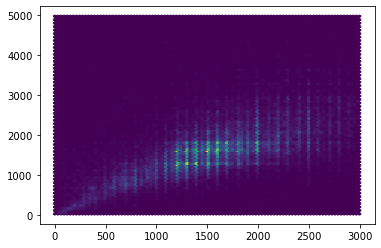

In [143]:
mdperf = perfestim(df=mtest.loc[:,traincols+["SALMEERED"]], model=mdmodel, predvar=predicted)
print(mdperf[1])
mdperf18 = perfestim(df=mtest18.loc[:,traincols+["SALMEERED"]], model=mdmodel, predvar=predicted)
mdperf18t1 = perfestim(df=mtest18.loc[mtest18.TRIM_1==1,traincols+["SALMEERED"]], model=mdmodel, predvar=predicted)
mdperf18t1r1 = perfestim(df=mtest18.loc[(mtest18.TRIM_1==1)&(mtest18.RGA_1==1),traincols+["SALMEERED"]], model=mdmodel, predvar=predicted)
print(mdperf18[1])
print(mdperf18t1[1])
print(mdperf18t1r1[1])
df18 = mdperf18[0]
plt.hexbin(df18.loc[(df18[predicted]<3000)&(df18["SALPRED"]<5000),predicted], 
           df18.loc[(df18[predicted]<3000)&(df18["SALPRED"]<5000),"SALPRED"])

In [144]:
del(Mincerd)
del(mddata)
gc.collect()

29

In [395]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                     datasave2:  7.9 GiB
                            df:  2.3 GiB
                      train_df:  1.4 GiB
                       test_df: 142.5 MiB
                         mtest: 119.8 MiB
                       x_train: 92.5 MiB
                           t18: 66.9 MiB
                     test18_df: 66.1 MiB
                      pred3_df: 37.4 MiB
                       mtest18: 37.0 MiB


In [394]:
del(pred4_df)
gc.collect()

21